In [70]:
import pandas as pd
import re
# Load Reading Girls Data
df = pd.read_csv("data/SessionPlaytestResults.csv")

original_before_words = []
for a in pd.concat([df['Being a scientist means....Pre'+str(i)] for i in range(1,6)]).fillna(''):
    original_before_words = original_before_words + a.split()
    
original_before_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in original_before_words] 

original_after_words = []
for a in pd.concat([df['Being a scientist means....Post'+str(i)] for i in range(1,6)]).fillna(''):
    original_after_words = original_after_words + a.split()

original_after_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in original_after_words]

In [71]:
# Load Reading Girls Data
df = pd.read_csv("data/RGS_raw_feedback.csv")

rgs_before_words = []
for a in df['Being a scientist means? Before'].fillna(''):
    rgs_before_words = rgs_before_words + a.split()
    
rgs_before_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in rgs_before_words] 

rgs_after_words = []
for a in df['Being a scientist means? After'].fillna(''):
    rgs_after_words = rgs_after_words + a.split()

rgs_after_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in rgs_after_words] 

In [72]:
# Load Print and play data
df = pd.read_csv("data/Questionaire_Responces.csv")

pnp_before_words = []
for a in df['Q5'].fillna(''):
    pnp_before_words = pnp_before_words + a.split()

pnp_before_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in pnp_before_words] 

In [73]:
# Load Social Mobility Foundation Data
df = pd.read_csv("data/BoardgamePPSMF.csv")

smf_before_words = []
for a in df['Claire Edited -Tiny Edits'].fillna(''):
    smf_before_words = smf_before_words + a.split()

smf_before_words = [re.sub(r'[^\w\s]', '', x.lower()) for x in smf_before_words]


In [74]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np

x, y = np.ogrid[:3000, :3000]

mask = (x - 1500) ** 2 + (y - 1500) ** 2 > 1300 ** 2
mask = 255 * mask.astype(int)
mask = mask[::2,:]

wordcloud = WordCloud(width=3000,
                    height=2000,
                    random_state=1, 
                    background_color='white',
                    mask=mask,
                    colormap='viridis', 
                    collocations=False, 
                    stopwords=STOPWORDS,
                    max_words=1000)

In [75]:
import urllib.request, json 
sentiment_url = 'https://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v2'
raw_sentiment = None
with urllib.request.urlopen(sentiment_url) as url:
    raw_sentiment = json.loads(url.read().decode())

In [76]:
sentiment = {}
for item in raw_sentiment['objects']:
    sentiment[item['word']] = (item['happs'], item['stdDev'])

In [77]:
frequencies = {}
ranges = {}
disp = {}
import csv
with open('textassets/1_1_all_fullalpha.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        key = row[0].lower()
        if key in frequencies:
            frequencies[key] += int(row[1])
            ranges[key] = max(int(row[2]),ranges[key])
            disp[key] = max(float(row[3]), disp[key])
        else:
            frequencies[key] = int(row[1])
            ranges[key] = int(row[2])
            disp[key] = float(row[3])


In [78]:
import pandas as pd
def create_top_word_dataframe(wordcloud, words, number_of_top_words=20):
    if number_of_top_words == None:
        number_of_top_words = len(wordcloud.words_.keys())
        print("New number of words "+str(number_of_top_words))
    data = []
    data.append(['laughter', None, sentiment['laughter'][0], None, None, None, frequencies['laughter'], sentiment['laughter'][0]])
    for i in range(number_of_top_words):
        word = list(wordcloud.words_.keys())[i]
        value = words.count(word) + words.count(word+'s')
        happy_s, happy_std, freq, ran, di = (None, None, 1, 0, 0)
        if word in sentiment:
            happy_s, happy_std = sentiment[word]
        if word in frequencies:
            freq = frequencies[word]
            ran = ranges[word]
            di = disp[word]
        data.append([word, value, happy_s, happy_std, freq, ran, di, None])
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ['Word', 'Times used', 'Happiness Score', 'Happiness StDev', 'Corpus Frequency','Corpus Range','Corpus Disp', 'Examples'])
    df = df.sort_values(by=['Happiness Score','Times used'], ascending=False)
    df_new_rows = pd.DataFrame({'Word':['sadness'], 'Happiness Score':[sentiment['sadness'][0]], 'Examples':[sentiment['sadness'][0]]})
    df = pd.concat([df, df_new_rows], ignore_index=True)
    df['Weighted mean'] = (df['Times used'] * df['Happiness Score']).sum() / (df['Times used'] * df['Happiness Score']/df['Happiness Score']).sum()
    return df

In [79]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

def plot_word_analysis(data_frame, save_name, is_pre_survey, group_name):
    survey_text = "Post"
    if is_pre_survey:
        survey_text = "Pre"
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    ax2=ax.twinx()

    ax.bar(data_frame['Word'],data_frame['Happiness Score'], color=pl.cm.viridis(0.2), label='Happiness Score')
    ax.bar(data_frame['Word'],data_frame['Examples'], color=pl.cm.viridis(0.4), label='Examples', hatch='//')
    ax2.scatter(data_frame['Word'],data_frame['Times used'], color=pl.cm.viridis(0.9), marker='D', label='Times Used')
    ax.plot(data_frame['Word'],data_frame['Weighted mean'], color=pl.cm.viridis(0.6), label='Weighted Mean')
    ax.set_xlabel('Word')
    ax.set_ylabel('Happiness Score')
    ax2.set_ylabel('Number of times seen')
    ax2.set_ylim(bottom=None,top=(ax2.get_ylim()[1]*1.35))
    ax.set_title("The happiness score and occurence of the top "+ str(len(data_frame)-2) +
                 " answers to the " +
                 survey_text +
                 "-play\nsurvey question ‘Being a Scientist Means?’ for the " +
                 group_name +
                 ".\n‘Laughter’ and ‘Sadness’ values provided as references.")

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right", va='center',
             rotation_mode="anchor")

    #legend
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles += handles2
    labels += labels2
    plt.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.savefig('figures/'+save_name+'.png')
    plt.show()

In [80]:
wordcloud.generate(' '.join(original_before_words))
original_df_before = create_top_word_dataframe(wordcloud, original_before_words)
original_df_before

,Word,Times used,Happiness Score,Happiness StDev,Corpus Frequency,Corpus Range,Corpus Disp,Examples,Weighted mean
0,laughter,NaN,8.50,NaN,NaN,NaN,22.00,8.50,6.115644
1,smart,11.0,7.48,1.37,19.0,99.0,0.93,NaN,6.115644
2,creative,5.0,7.40,1.20,25.0,99.0,0.90,NaN,6.115644
3,clever,4.0,7.06,1.35,24.0,98.0,0.92,NaN,6.115644
4,science,4.0,6.86,1.58,106.0,100.0,0.86,NaN,6.115644
5,understanding,3.0,6.84,1.17,95.0,100.0,0.93,NaN,6.115644
6,new,5.0,6.82,1.14,1252.0,100.0,0.95,NaN,6.115644
7,world,4.0,6.52,1.66,590.0,100.0,0.96,NaN,6.115644
8,research,12.0,6.46,1.09,270.0,100.0,0.82,NaN,6.115644
9,thinking,3.0,6.28,1.29,135.0,100.0,0.96,NaN,6.115644


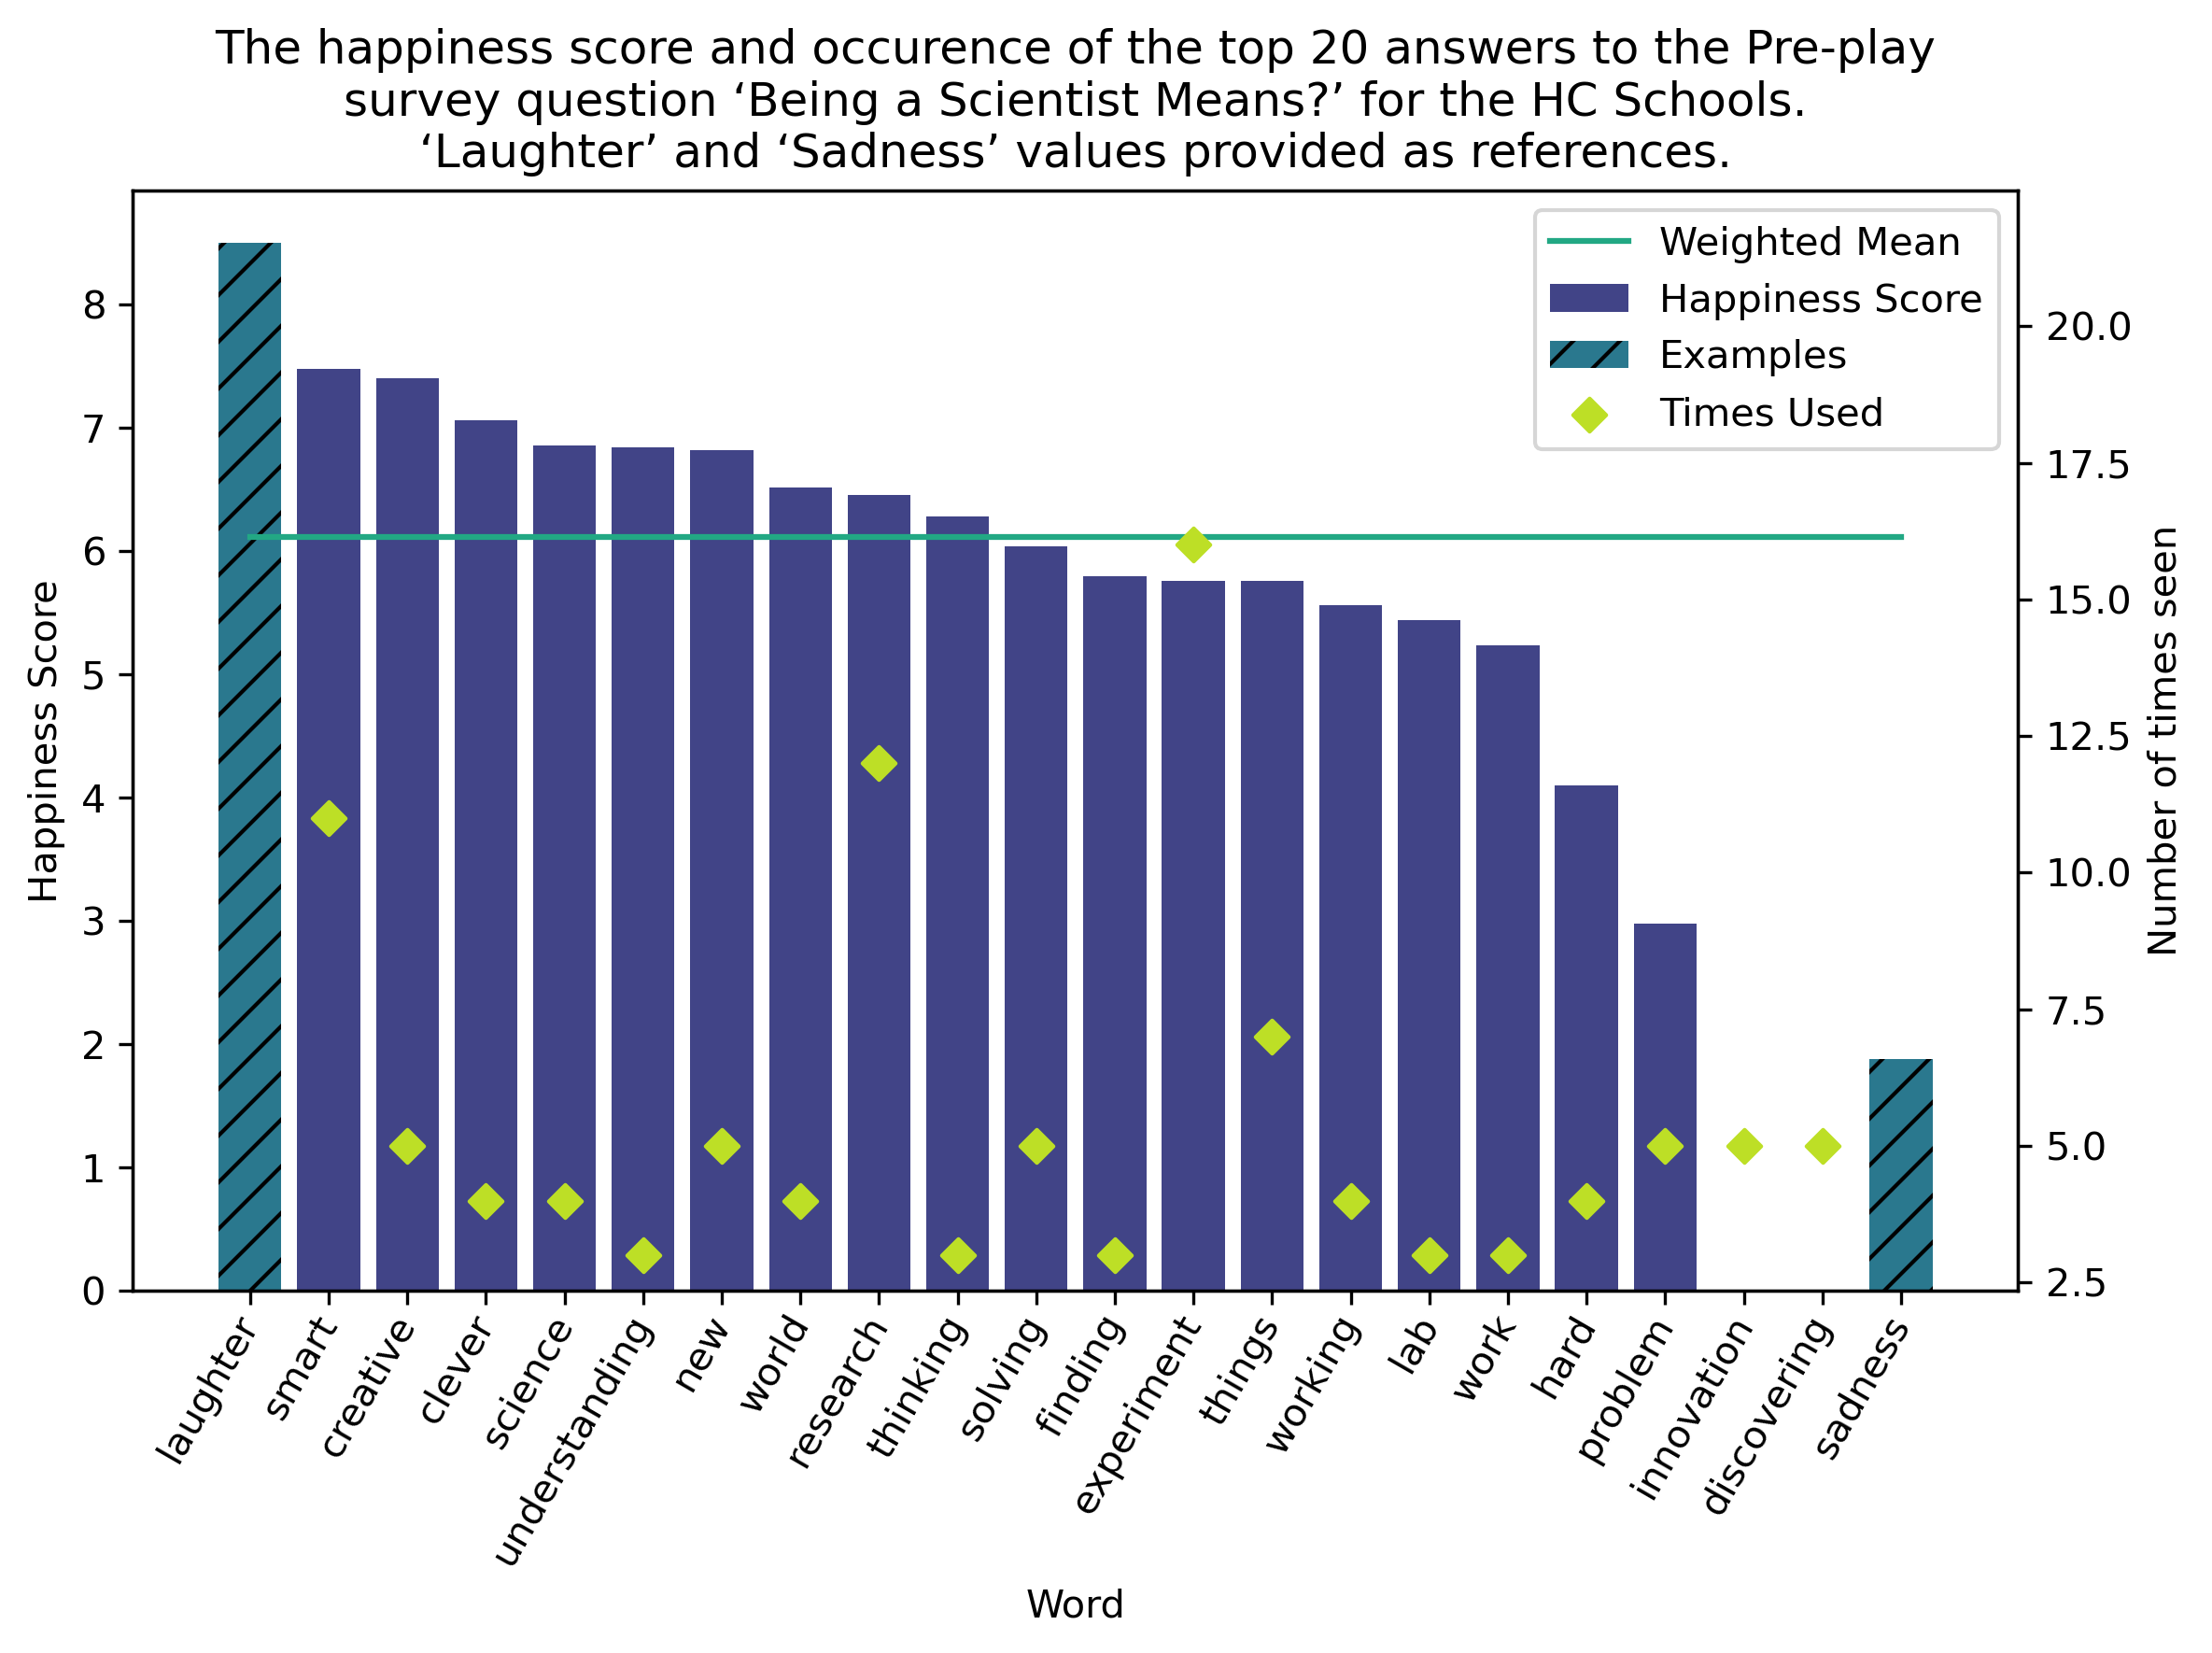

In [81]:
plot_word_analysis(original_df_before, 'OriginalWordAnalysisBefore', True, "HC Schools")

In [82]:
wordcloud.generate(' '.join(original_after_words))
original_df_after = create_top_word_dataframe(wordcloud, original_after_words)
original_df_after

,Word,Times used,Happiness Score,Happiness StDev,Corpus Frequency,Corpus Range,Corpus Disp,Examples,Weighted mean
0,laughter,NaN,8.50,NaN,NaN,NaN,22.00,8.50,5.556667
1,fun,2.0,7.96,1.31,51.0,98.0,0.94,NaN,5.556667
2,success,4.0,7.86,1.64,134.0,100.0,0.94,NaN,5.556667
3,lucky,1.0,7.68,1.27,41.0,98.0,0.93,NaN,5.556667
4,luck,2.0,7.26,1.88,32.0,99.0,0.93,NaN,5.556667
5,sharing,2.0,7.06,1.28,24.0,100.0,0.95,NaN,5.556667
6,improving,1.0,6.96,0.88,25.0,99.0,0.93,NaN,5.556667
7,science,2.0,6.86,1.58,106.0,100.0,0.86,NaN,5.556667
8,new,2.0,6.82,1.14,1252.0,100.0,0.95,NaN,5.556667
9,research,3.0,6.46,1.09,270.0,100.0,0.82,NaN,5.556667


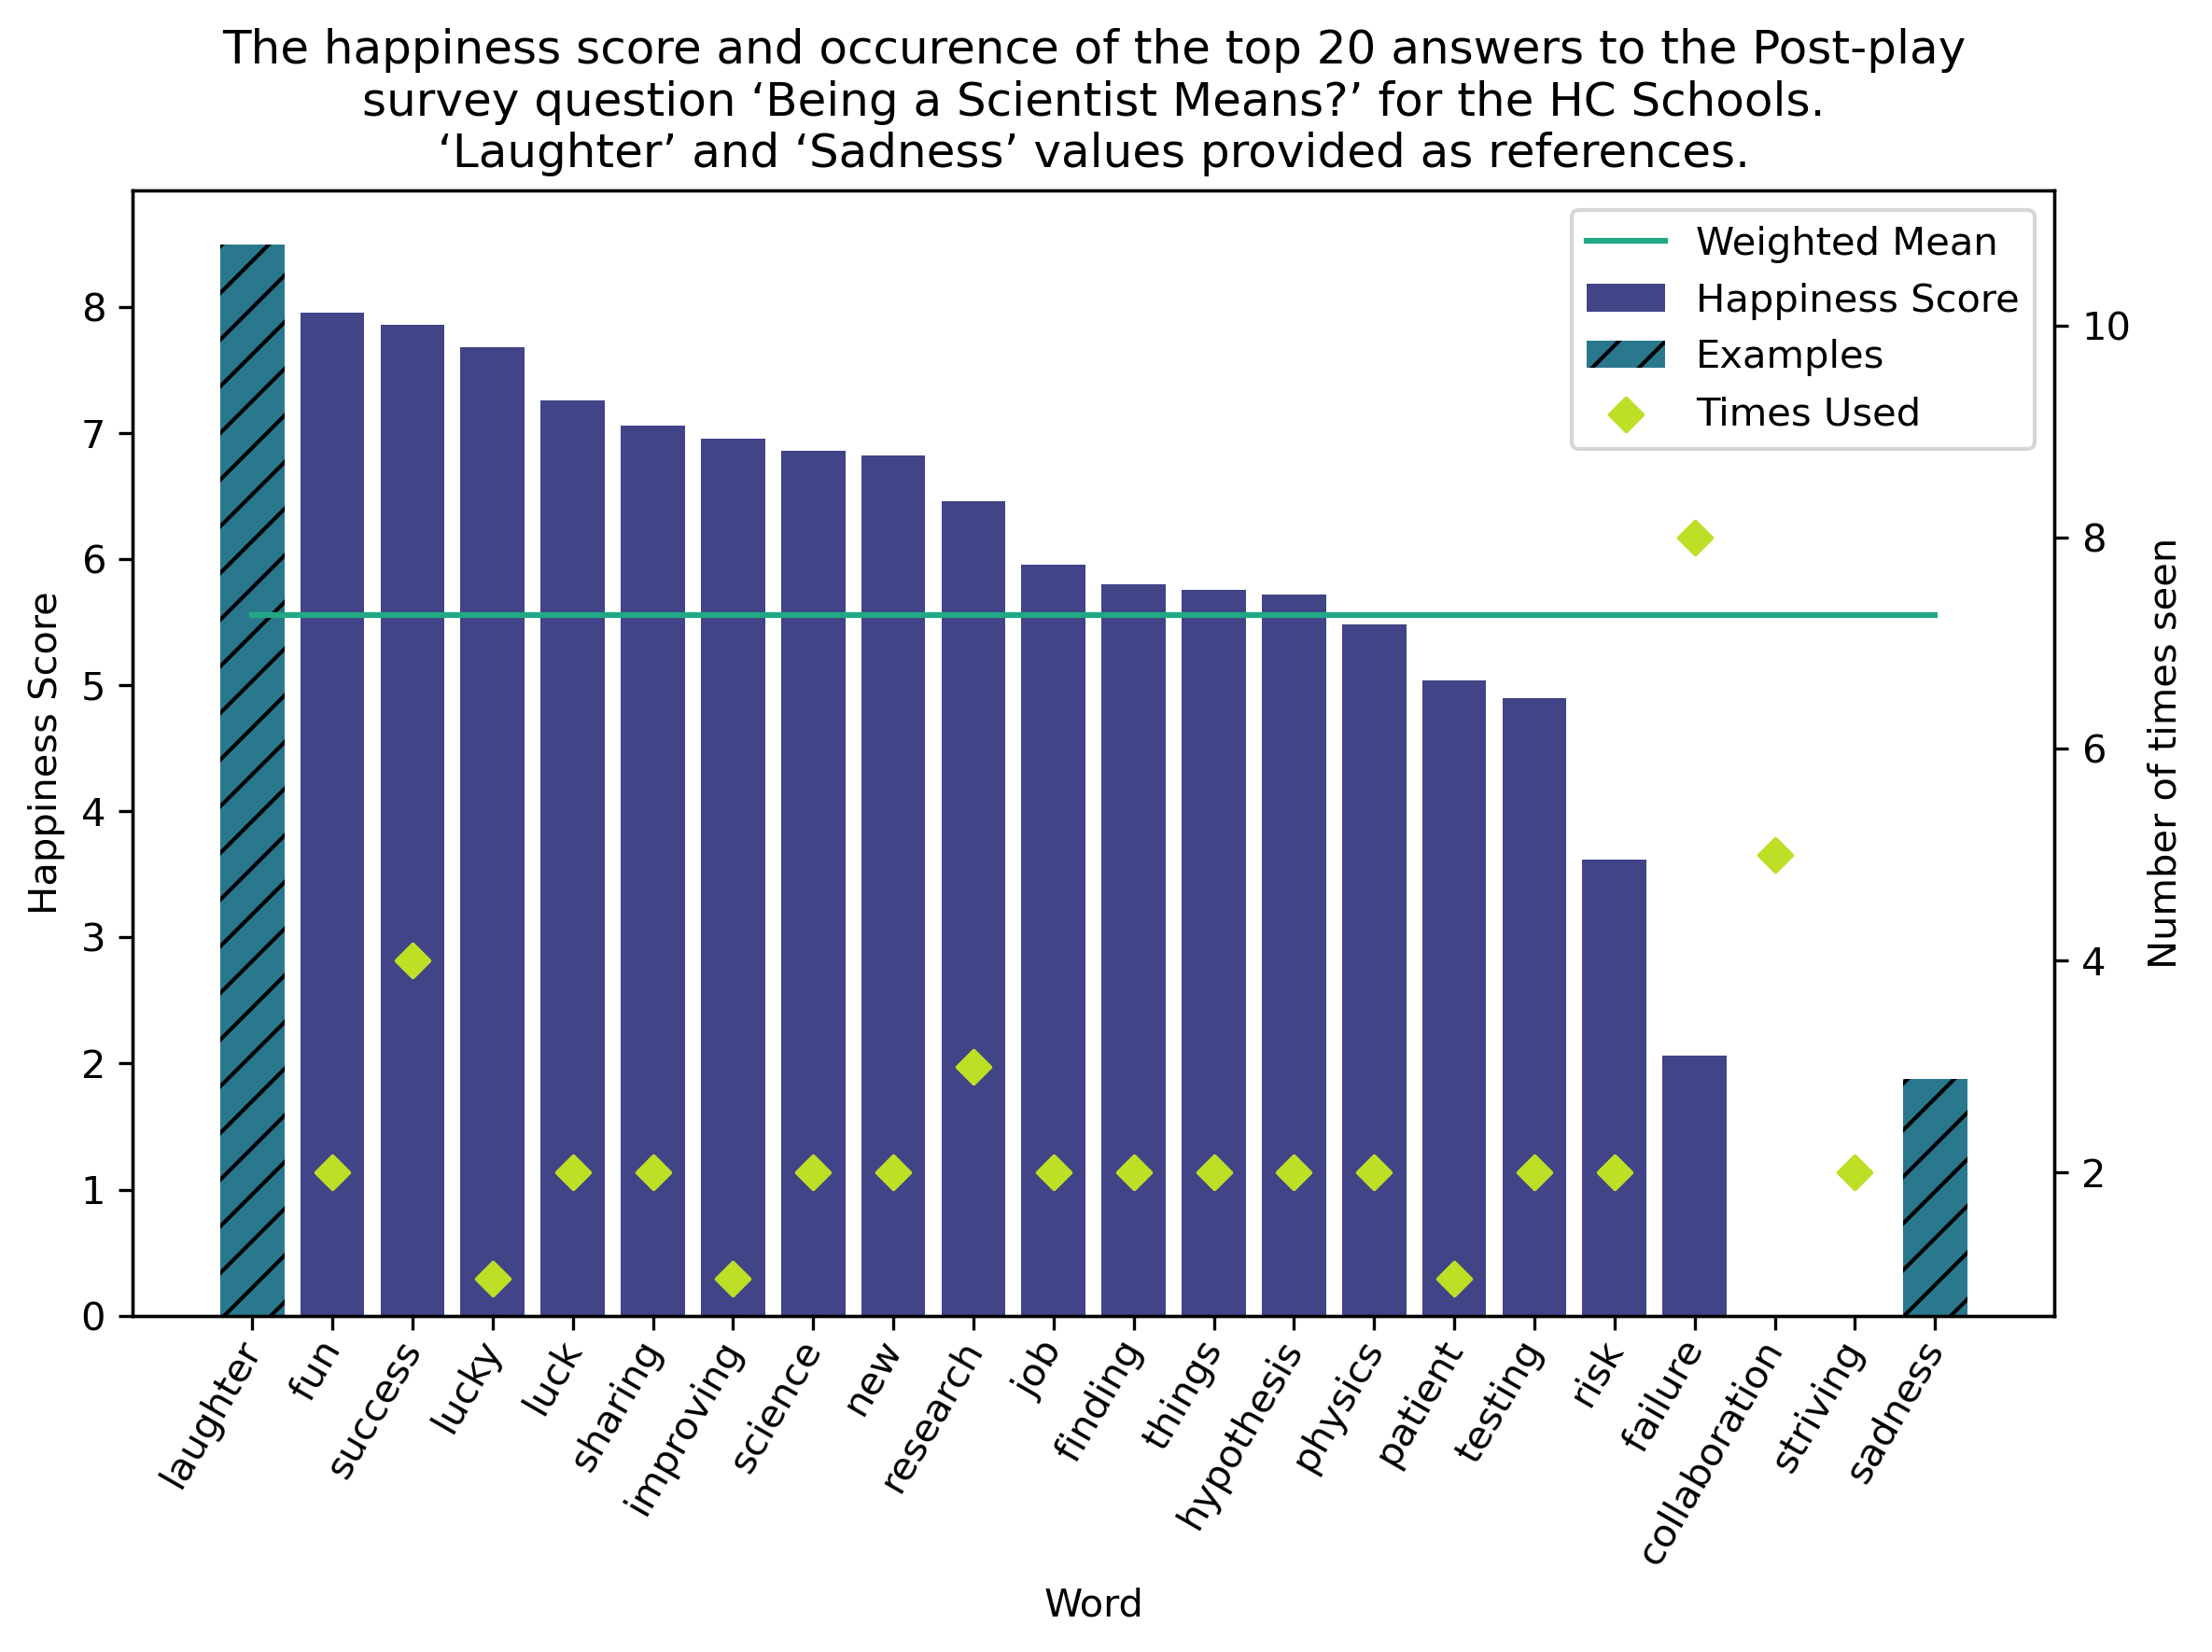

In [83]:
plot_word_analysis(original_df_after, 'OriginalWordAnalyisAfter', False, "HC Schools")

In [84]:
wordcloud.generate(' '.join(rgs_before_words))
rgs_df_before = create_top_word_dataframe(wordcloud, rgs_before_words)
rgs_df_before

,Word,Times used,Happiness Score,Happiness StDev,Corpus Frequency,Corpus Range,Corpus Disp,Examples,Weighted mean
0,laughter,NaN,8.50,NaN,NaN,NaN,22.00,8.50,6.022213
1,smart,14.0,7.48,1.37,19.0,99.0,0.93,NaN,6.022213
2,life,10.0,7.32,1.70,566.0,100.0,0.96,NaN,6.022213
3,knowledge,15.0,7.24,1.46,146.0,100.0,0.92,NaN,6.022213
4,discover,19.0,6.84,1.40,33.0,99.0,0.95,NaN,6.022213
5,new,18.0,6.82,1.14,1252.0,100.0,0.95,NaN,6.022213
6,research,12.0,6.46,1.09,270.0,100.0,0.82,NaN,6.022213
7,scientist,9.0,6.18,1.29,20.0,98.0,0.68,NaN,6.022213
8,study,9.0,6.12,1.62,222.0,100.0,0.93,NaN,6.022213
9,know,9.0,6.10,1.39,1234.0,100.0,0.86,NaN,6.022213


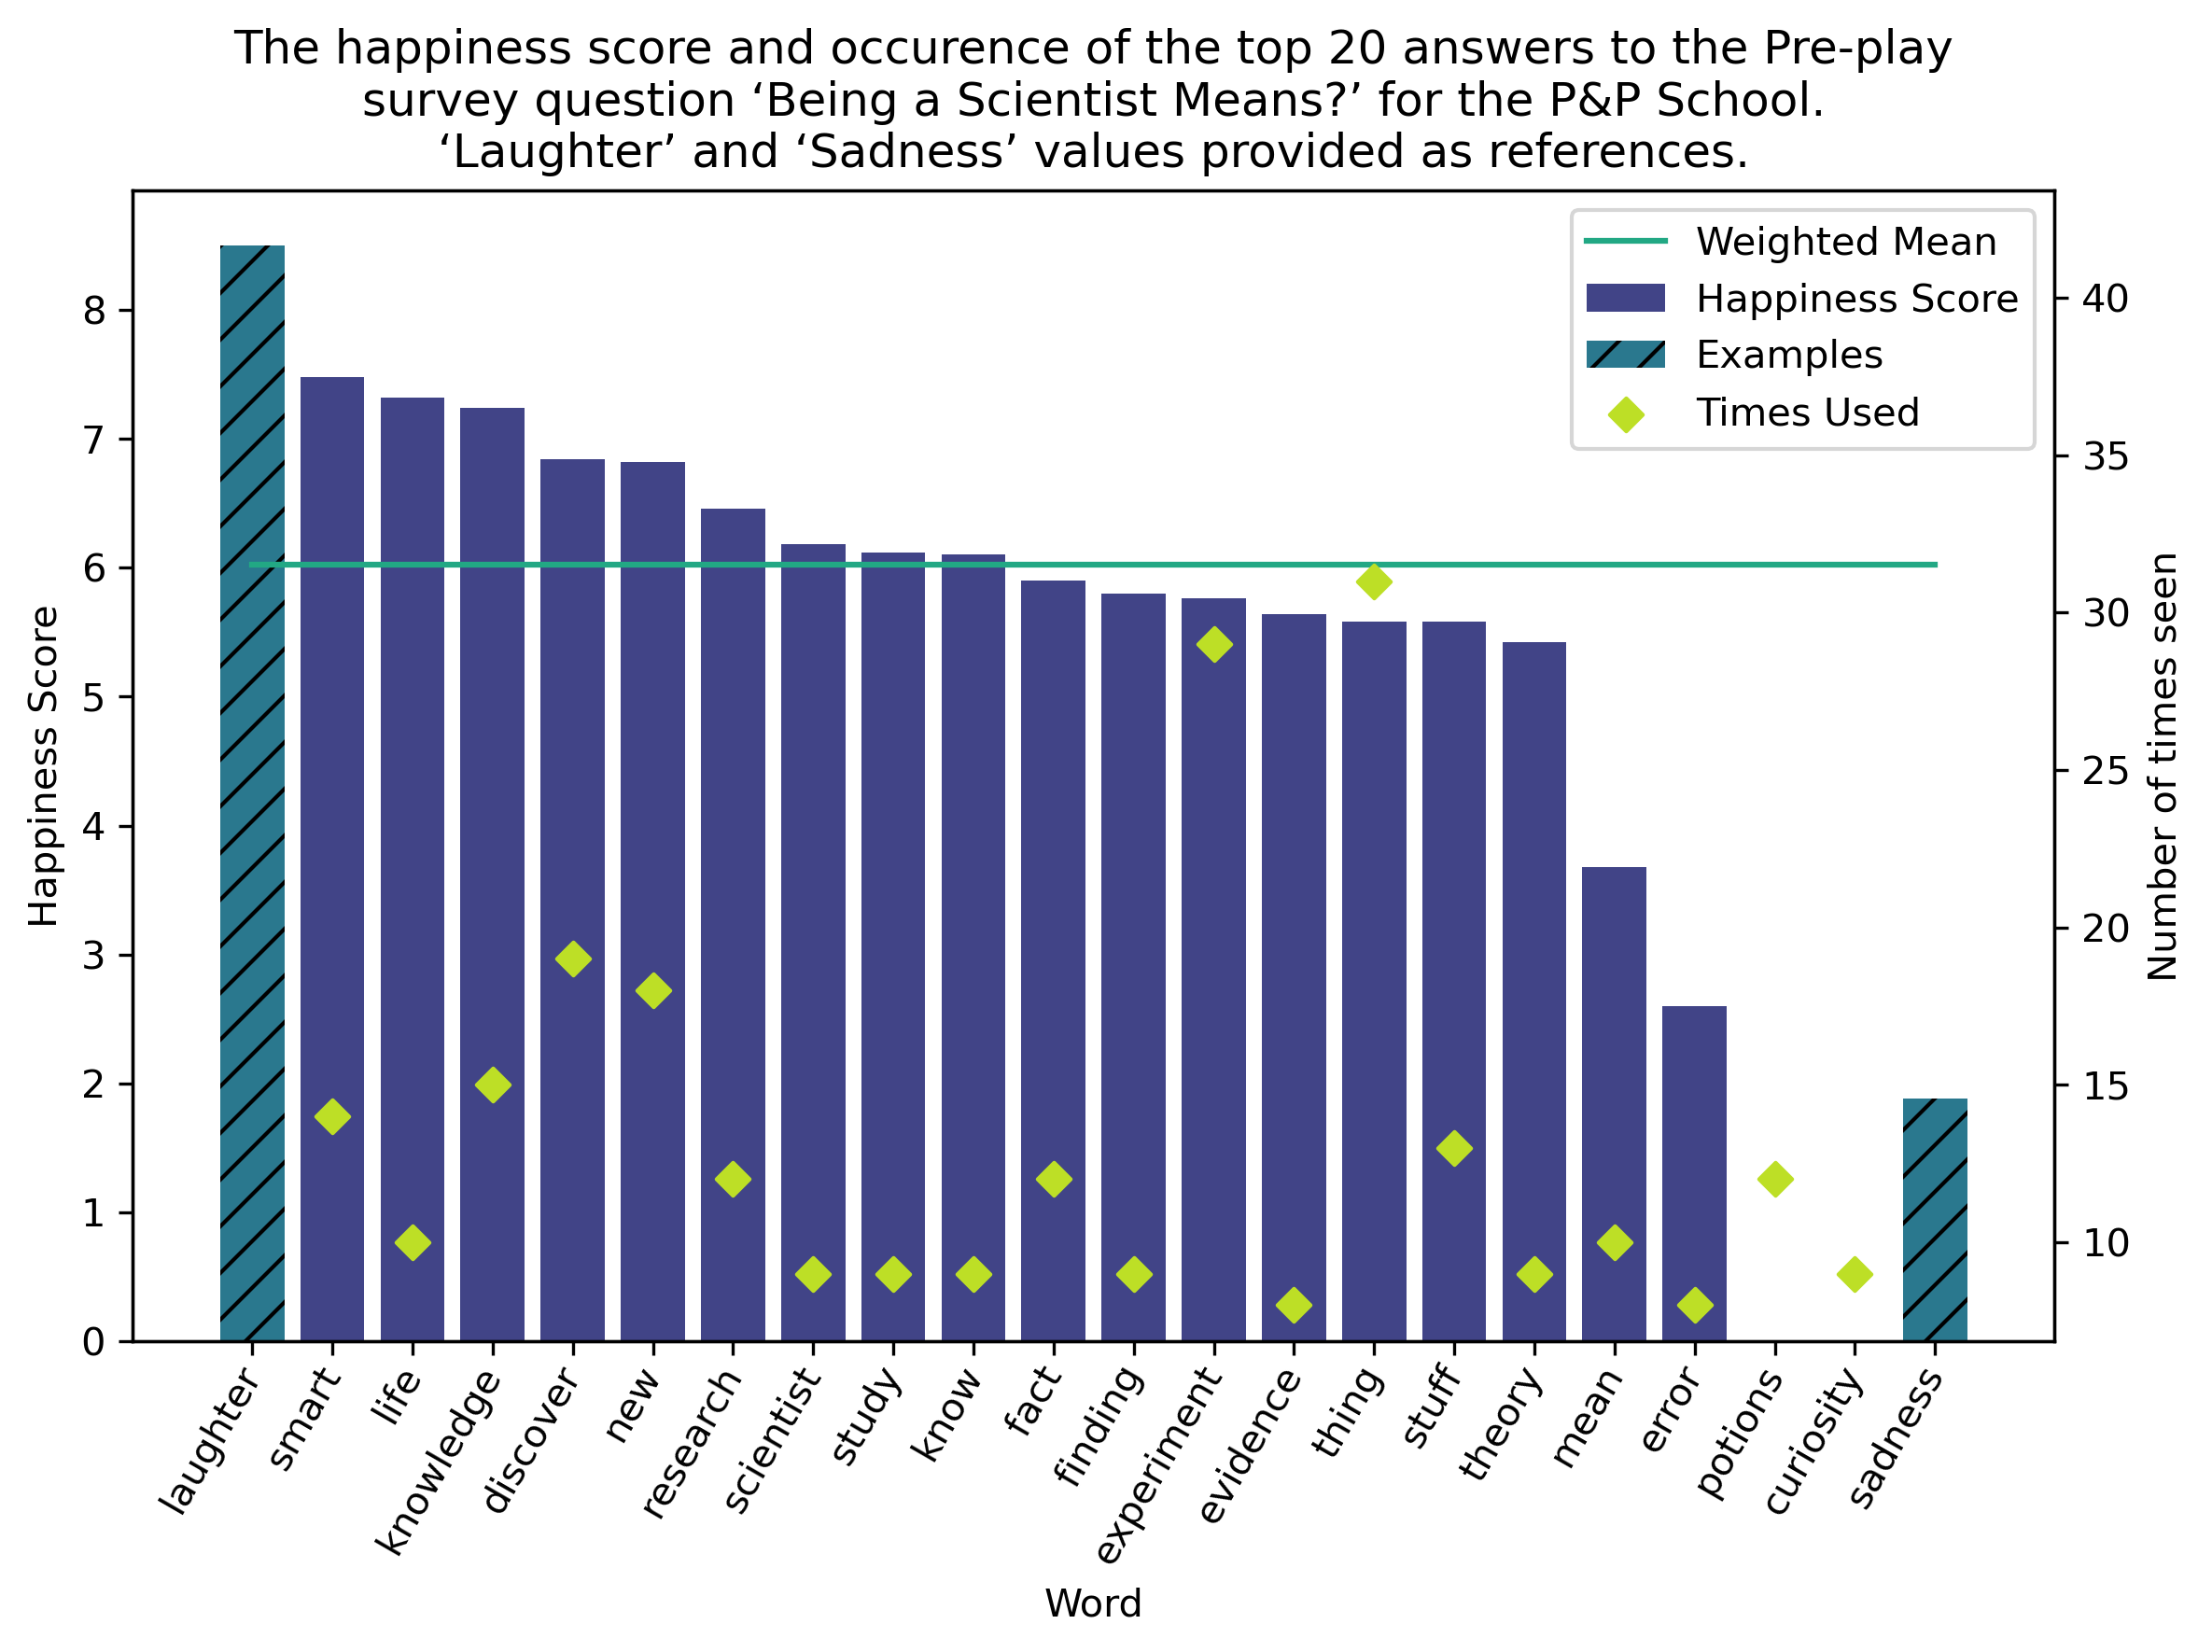

In [85]:
plot_word_analysis(rgs_df_before, 'RGSWordAnalyisBefore', True, "P&P School")

In [86]:
wordcloud.generate(' '.join(rgs_after_words))
rgs_df_after = create_top_word_dataframe(wordcloud, rgs_after_words)
rgs_df_after

,Word,Times used,Happiness Score,Happiness StDev,Corpus Frequency,Corpus Range,Corpus Disp,Examples,Weighted mean
0,laughter,NaN,8.50,NaN,NaN,NaN,22.00,8.50,6.069268
1,fun,5.0,7.96,1.31,51.0,98.0,0.94,NaN,6.069268
2,success,4.0,7.86,1.64,134.0,100.0,0.94,NaN,6.069268
3,smart,5.0,7.48,1.37,19.0,99.0,0.93,NaN,6.069268
4,good,4.0,7.20,1.46,825.0,100.0,0.95,NaN,6.069268
5,learning,7.0,6.92,1.35,92.0,99.0,0.93,NaN,6.069268
6,science,8.0,6.86,1.58,106.0,100.0,0.86,NaN,6.069268
7,new,7.0,6.82,1.14,1252.0,100.0,0.95,NaN,6.069268
8,scientist,6.0,6.18,1.29,20.0,98.0,0.68,NaN,6.069268
9,people,6.0,6.16,1.58,1241.0,100.0,0.95,NaN,6.069268


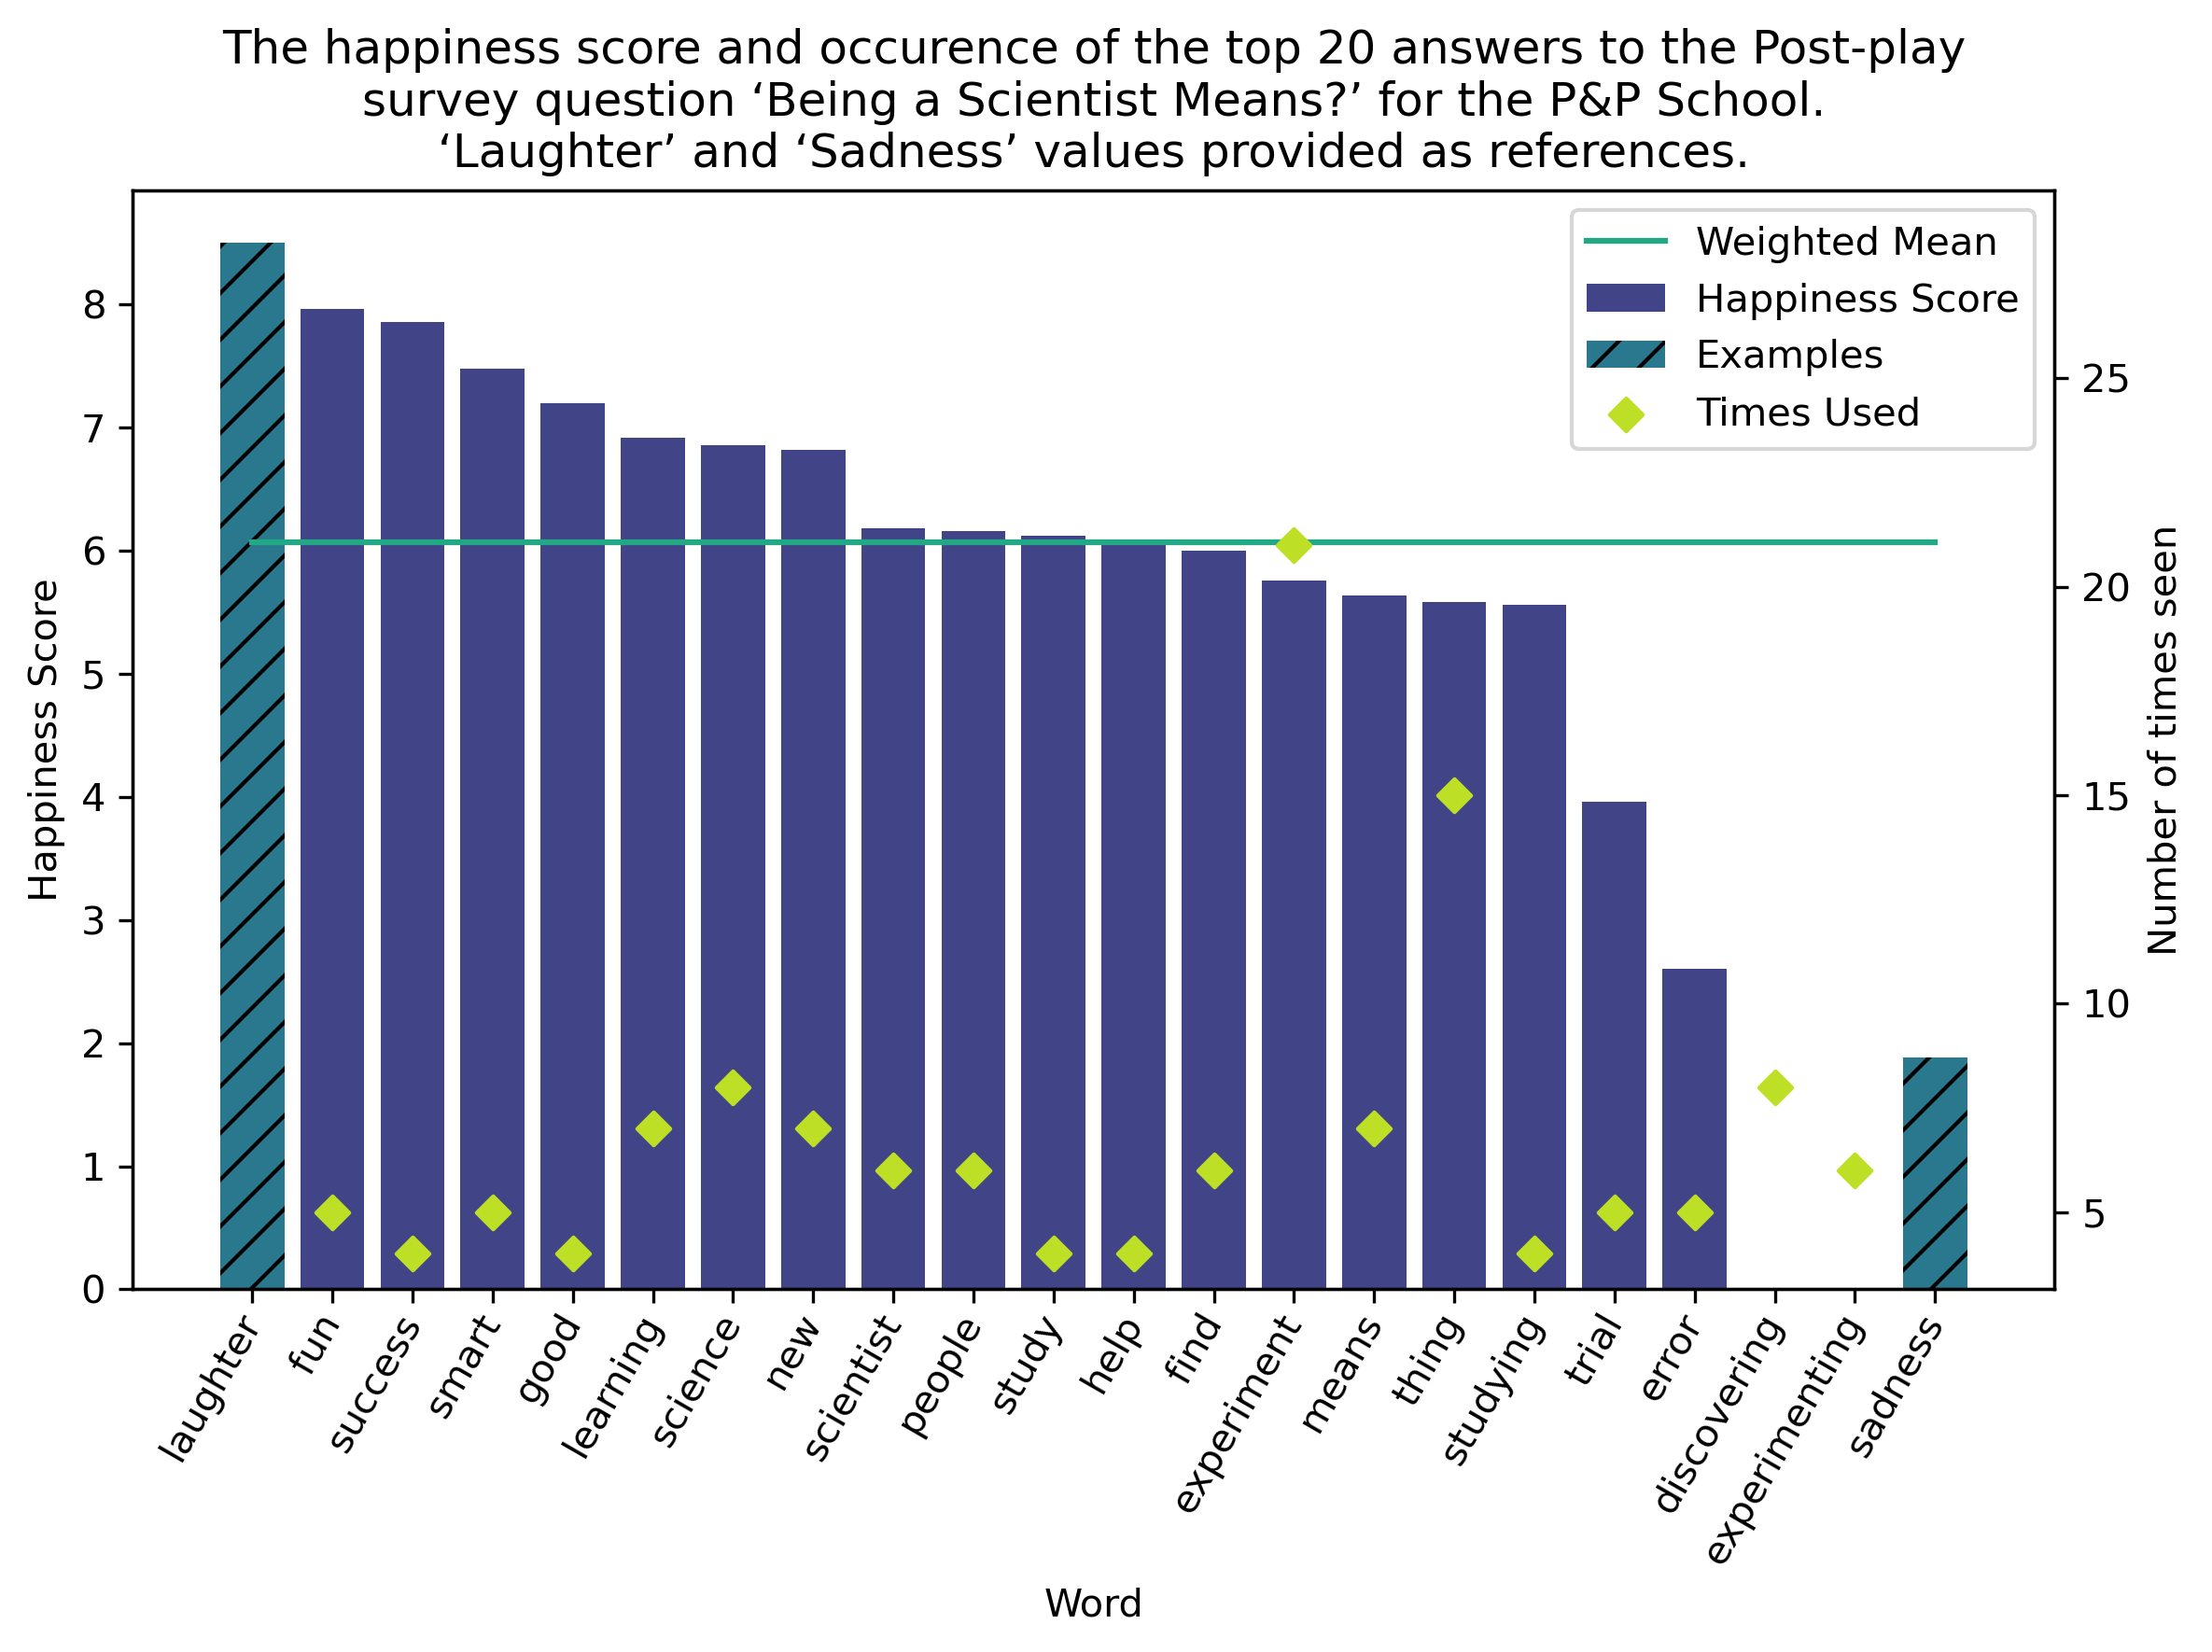

In [87]:
plot_word_analysis(rgs_df_after, 'RGSWordAnalyisAfter', False, "P&P School")

In [88]:
wordcloud.generate(' '.join(pnp_before_words))
pnp_df_before = create_top_word_dataframe(wordcloud, pnp_before_words, number_of_top_words=40)
len(pnp_df_before)

42

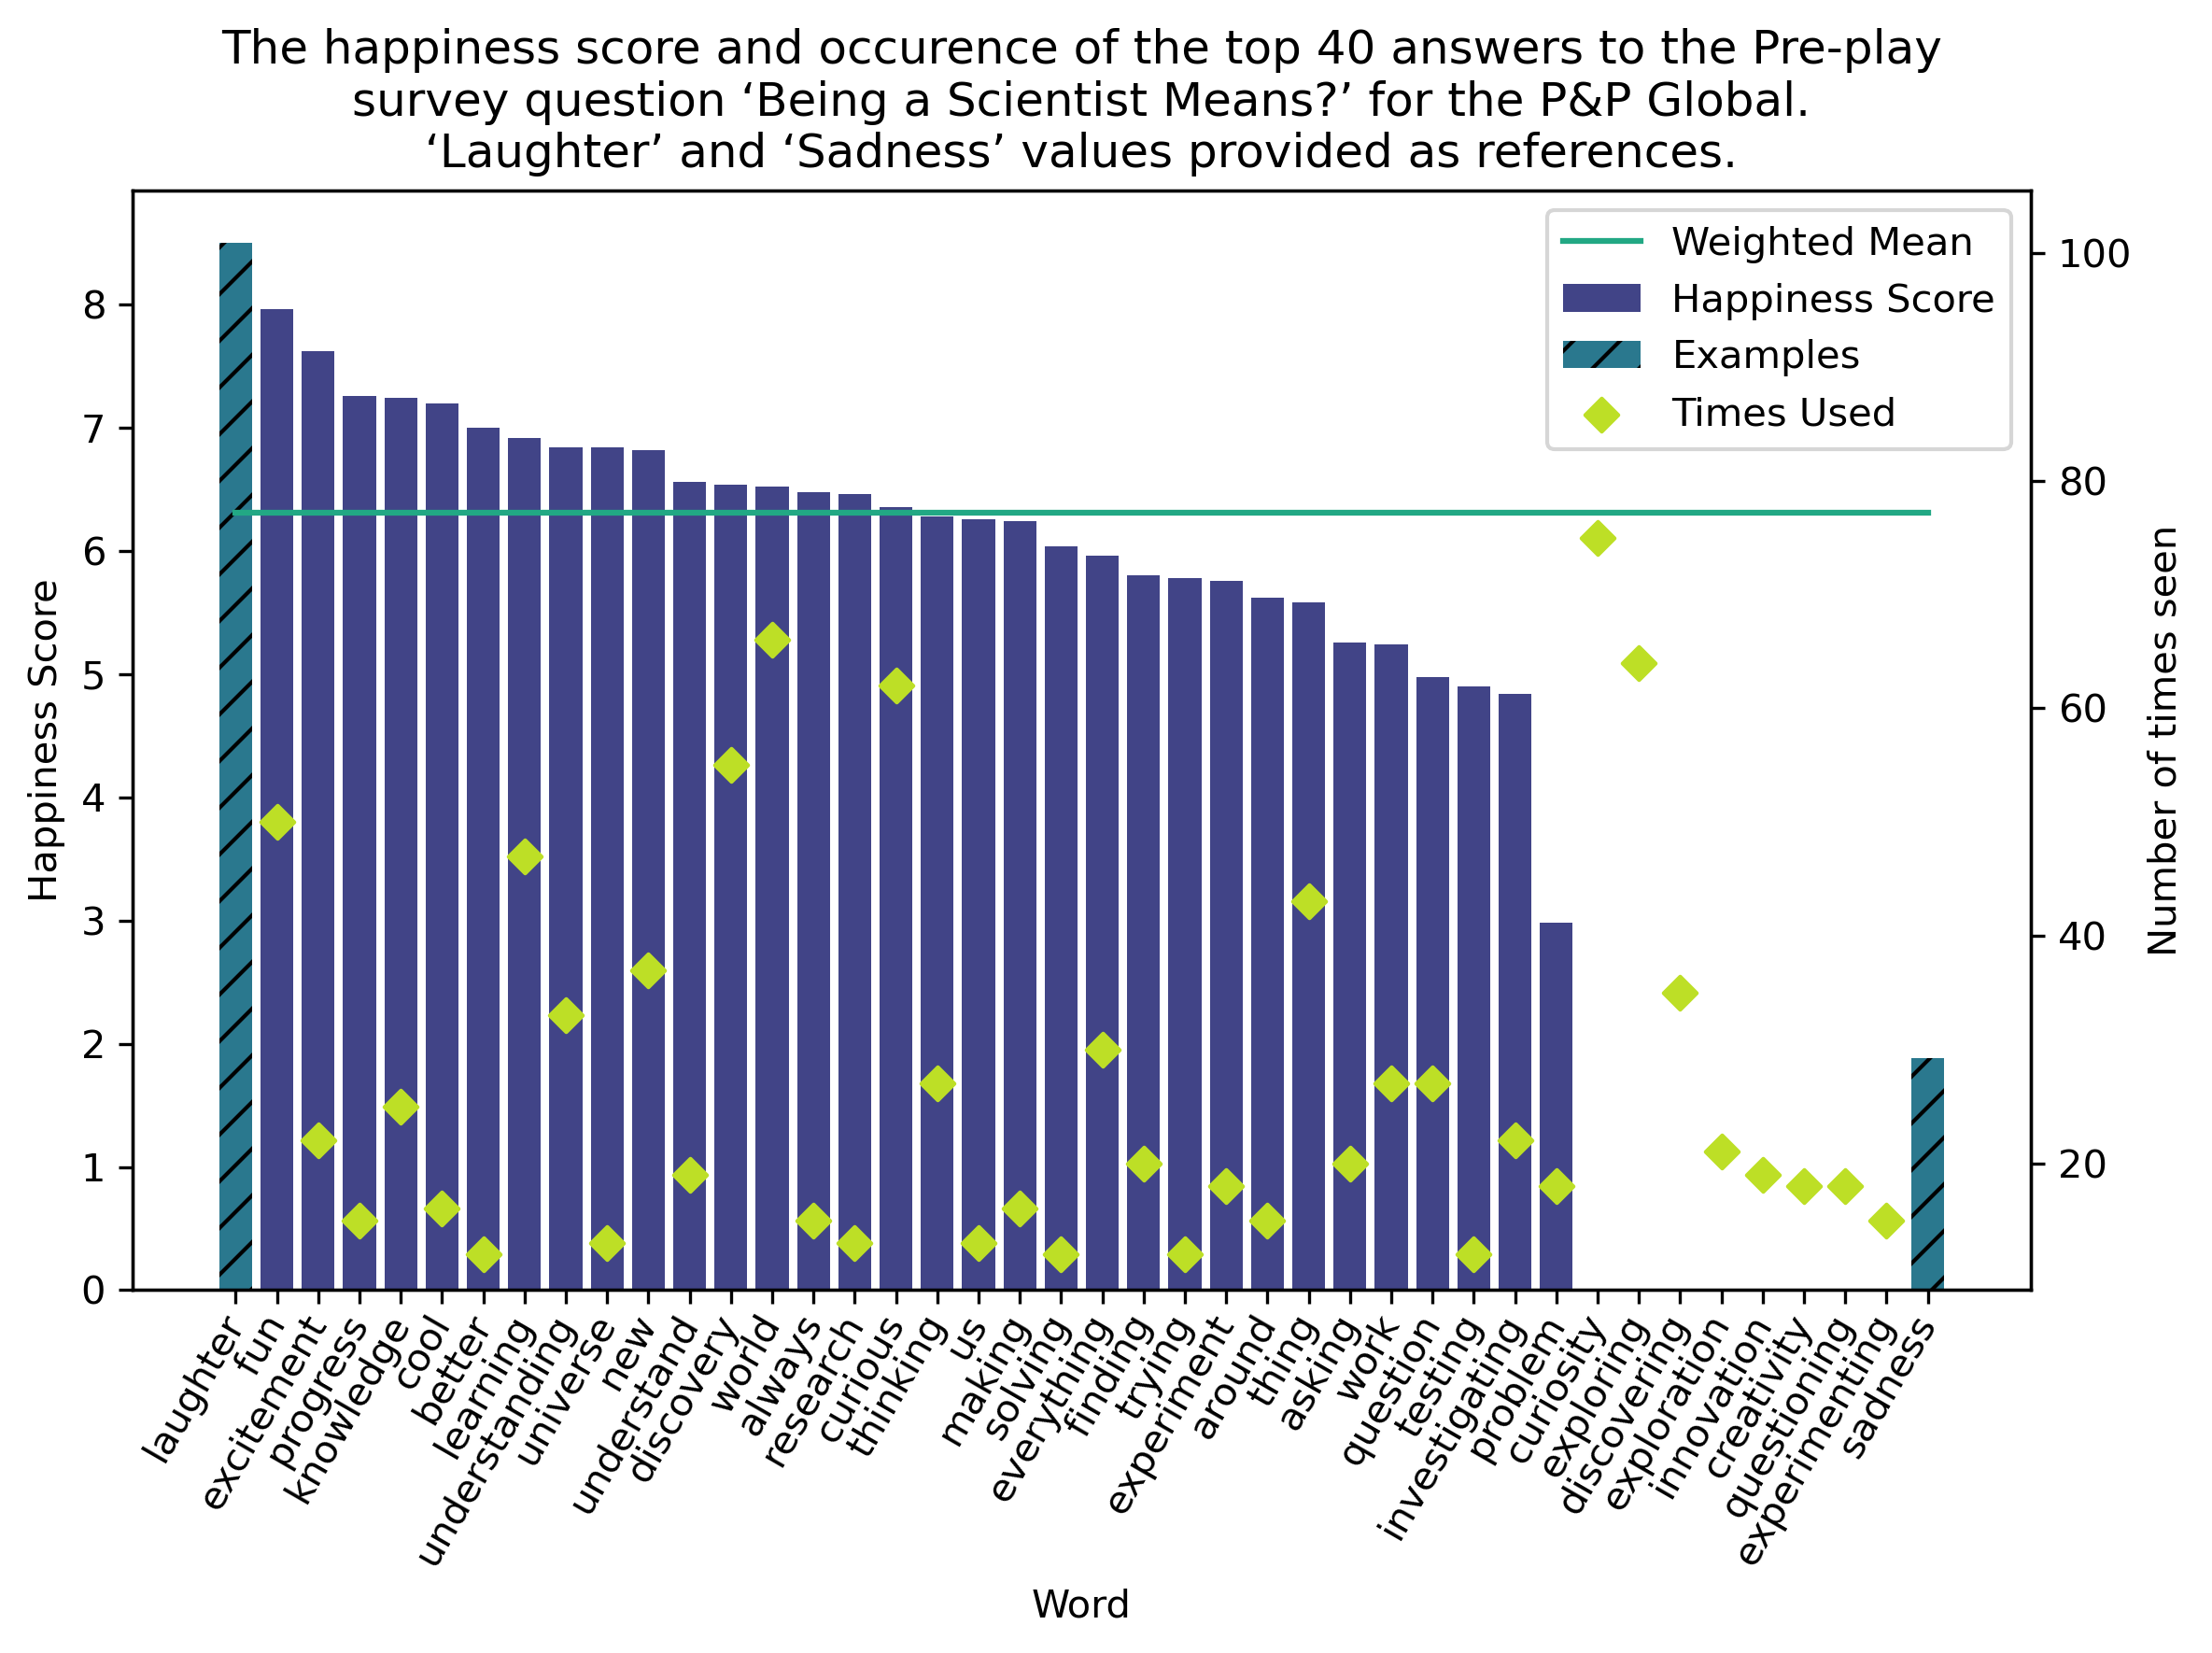

In [89]:
plot_word_analysis(pnp_df_before, 'PnPWordAnalyisBefore', True, "P&P Global")

In [90]:
wordcloud.generate(' '.join(smf_before_words))
smf_df_before = create_top_word_dataframe(wordcloud, smf_before_words)
len(smf_df_before)

22

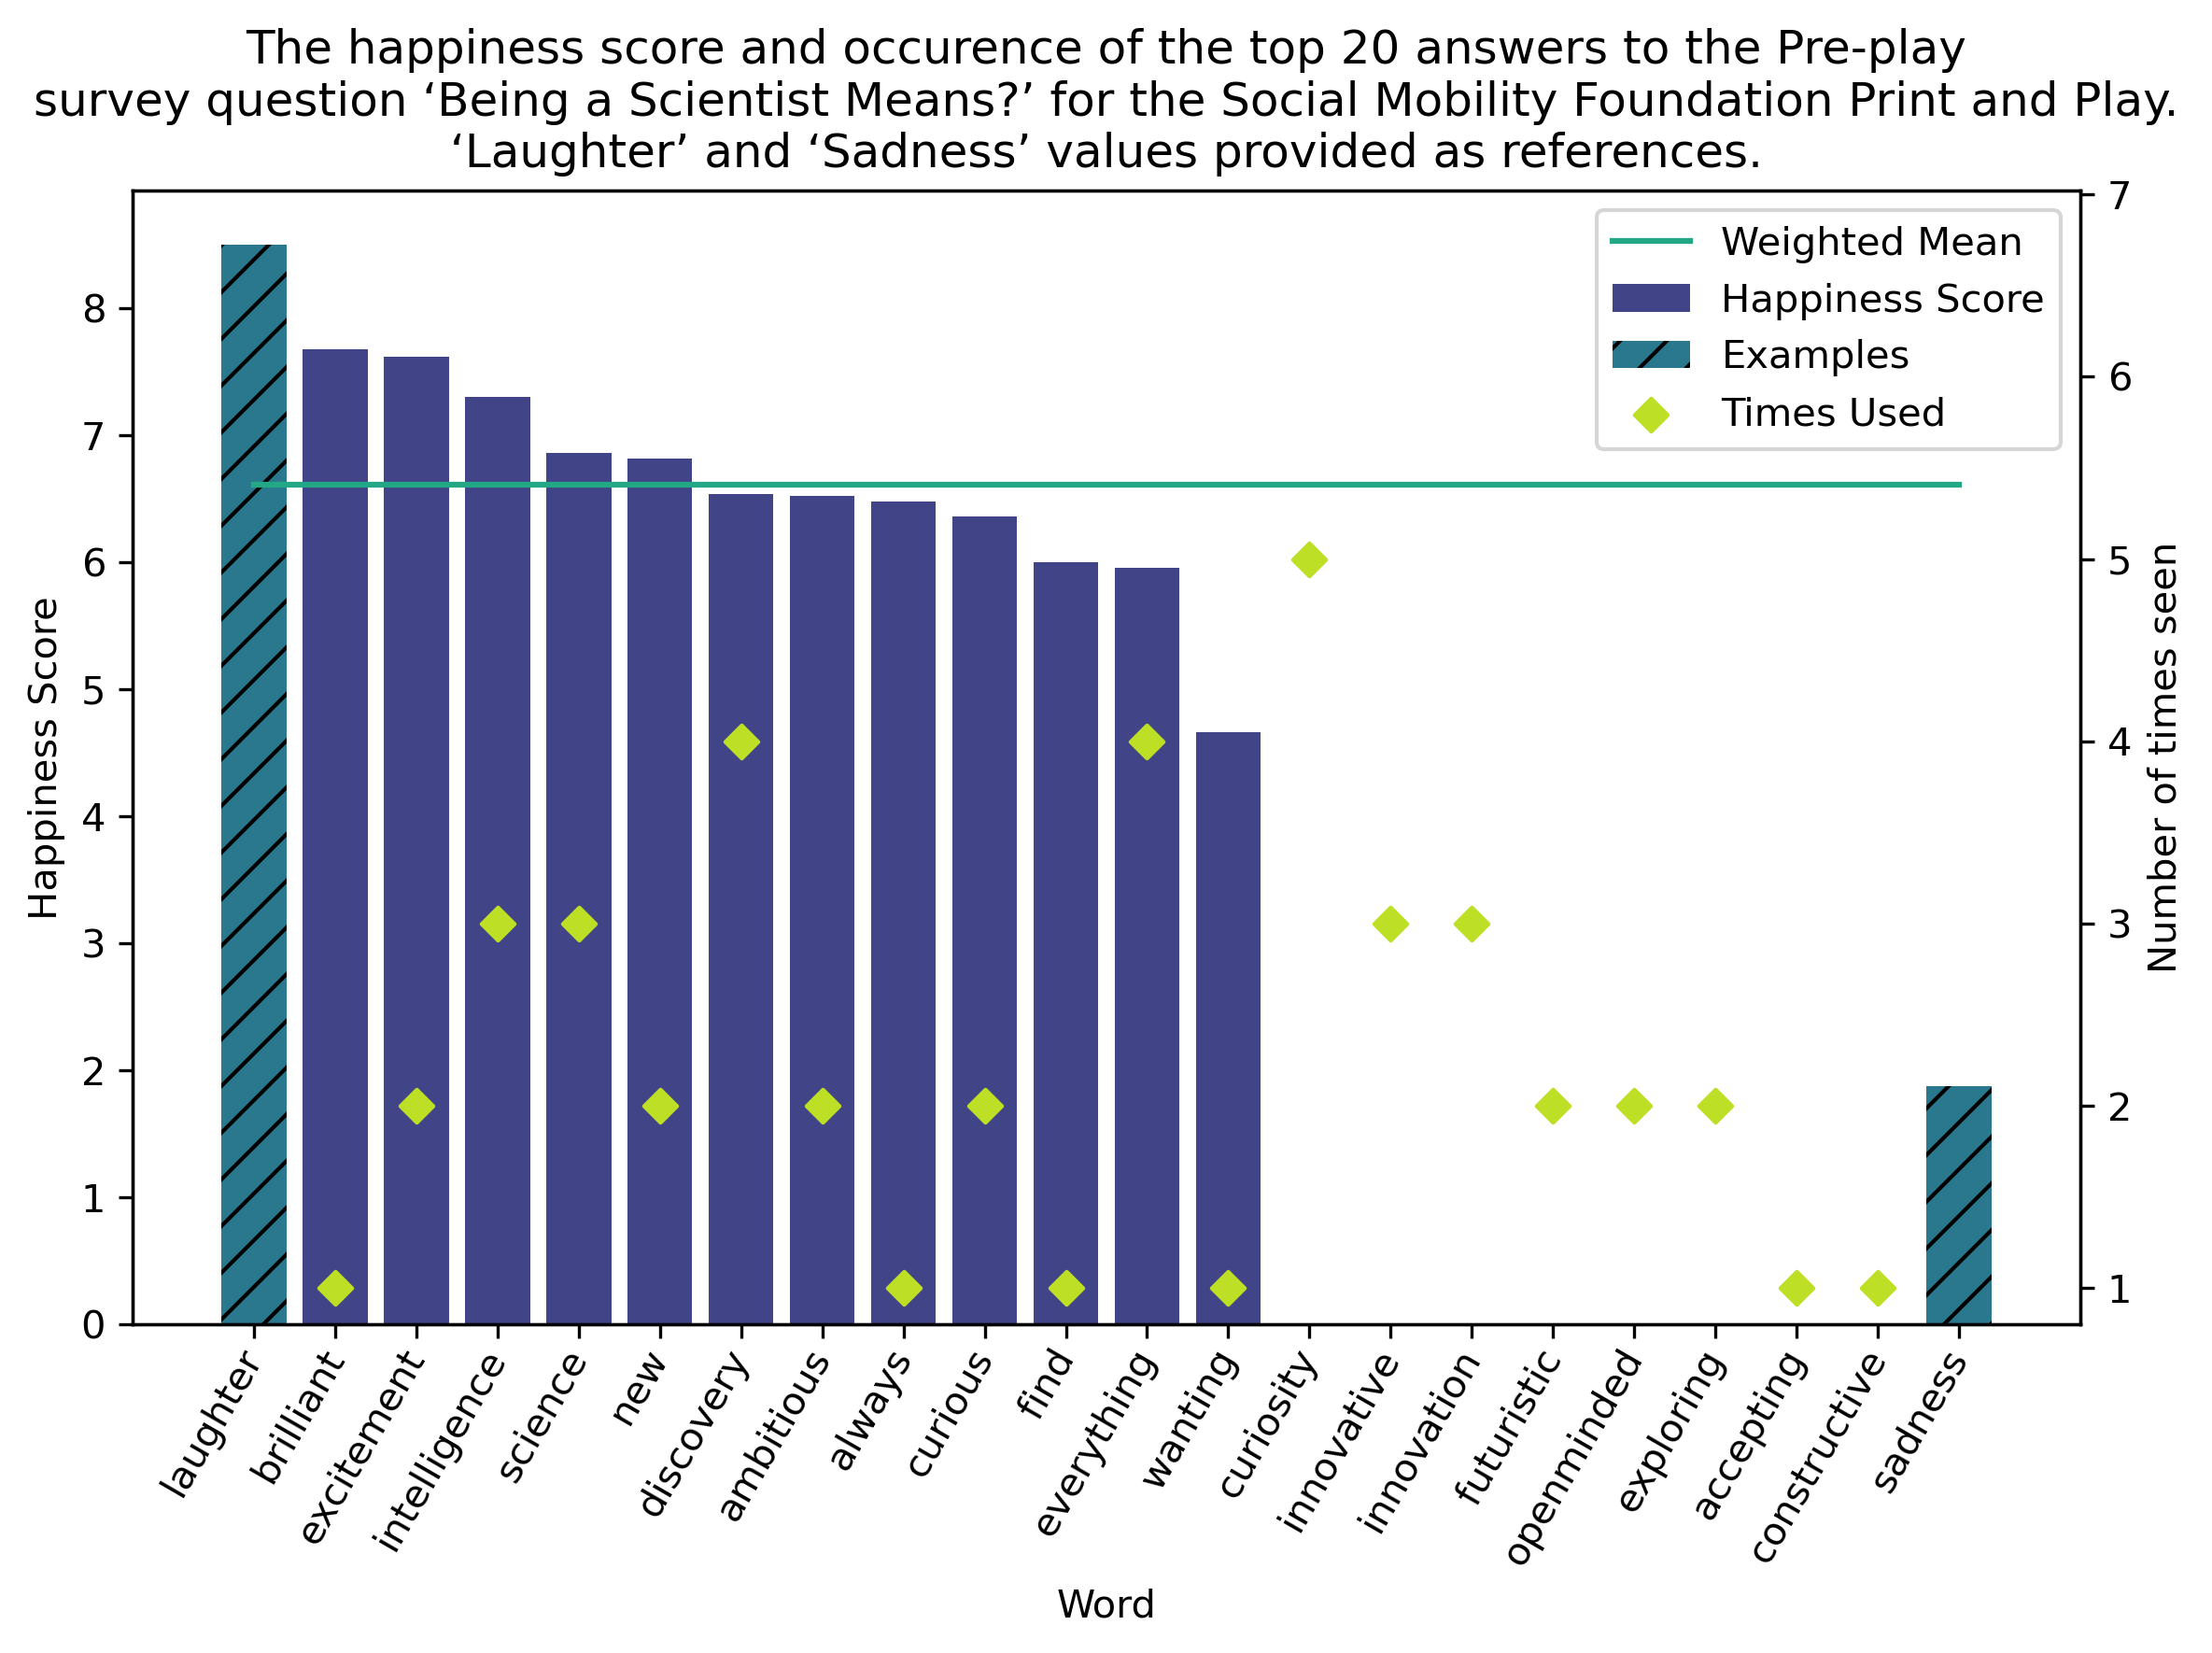

In [91]:
plot_word_analysis(smf_df_before, 'SMFWordAnalyisBefore', True, "Social Mobility Foundation Print and Play")

In [92]:
data = []

data.append(['HC Schools\nPre-survey',
             original_df_before[1:-1]['Weighted mean'].max(),
             original_df_before[1:-1]['Happiness Score'].max(),
             original_df_before[1:-1]['Happiness Score'].min(),
             original_df_before[1:-1]['Happiness Score'].std()#*1.5
            ])

data.append(['HC Schools\nPost-survey',
             original_df_after[1:-1]['Weighted mean'].max(),
             original_df_after[1:-1]['Happiness Score'].max(),
             original_df_after[1:-1]['Happiness Score'].min(),
             original_df_before[1:-1]['Happiness Score'].std()#*1.5
            ])

data.append(['P&P School\nPre-survey',
             rgs_df_before[1:-1]['Weighted mean'].max(),
             rgs_df_before[1:-1]['Happiness Score'].max(),
             rgs_df_before[1:-1]['Happiness Score'].min(),
             rgs_df_before[1:-1]['Happiness Score'].std()#*1.5
            ])

data.append(['P&P School\nPost-survey',
             rgs_df_after[1:-1]['Weighted mean'].max(),
             rgs_df_after[1:-1]['Happiness Score'].max(),
             rgs_df_after[1:-1]['Happiness Score'].min(),
             rgs_df_after[1:-1]['Happiness Score'].std()#*1.5
            ])

data.append(['P&P Global\nPre-survey',
             pnp_df_before[1:-1]['Weighted mean'].max(),
             pnp_df_before[1:-1]['Happiness Score'].max(),
             pnp_df_before[1:-1]['Happiness Score'].min(),
             pnp_df_before[1:-1]['Happiness Score'].std()#*1.5             
            ])

data.append(['SMF\nPre-survey',
             smf_df_before[1:-1]['Weighted mean'].max(),
             smf_df_before[1:-1]['Happiness Score'].max(),
             smf_df_before[1:-1]['Happiness Score'].min(),
             smf_df_before[1:-1]['Happiness Score'].std()#*1.5             
            ])

df = pd.DataFrame(data, columns = ['Name', 'Mean', 'Max', 'Min', 'std'])
df

,Name,Mean,Max,Min,std
0,HC Schools\nPre-survey,6.115644,7.48,2.98,1.135396
1,HC Schools\nPost-survey,5.556667,7.96,2.06,1.135396
2,P&P School\nPre-survey,6.022213,7.48,2.60,1.209373
3,P&P School\nPost-survey,6.069268,7.96,2.60,1.309030
4,P&P Global\nPre-survey,6.313125,7.96,2.98,0.979557
5,SMF\nPre-survey,6.613077,7.68,4.66,0.821012


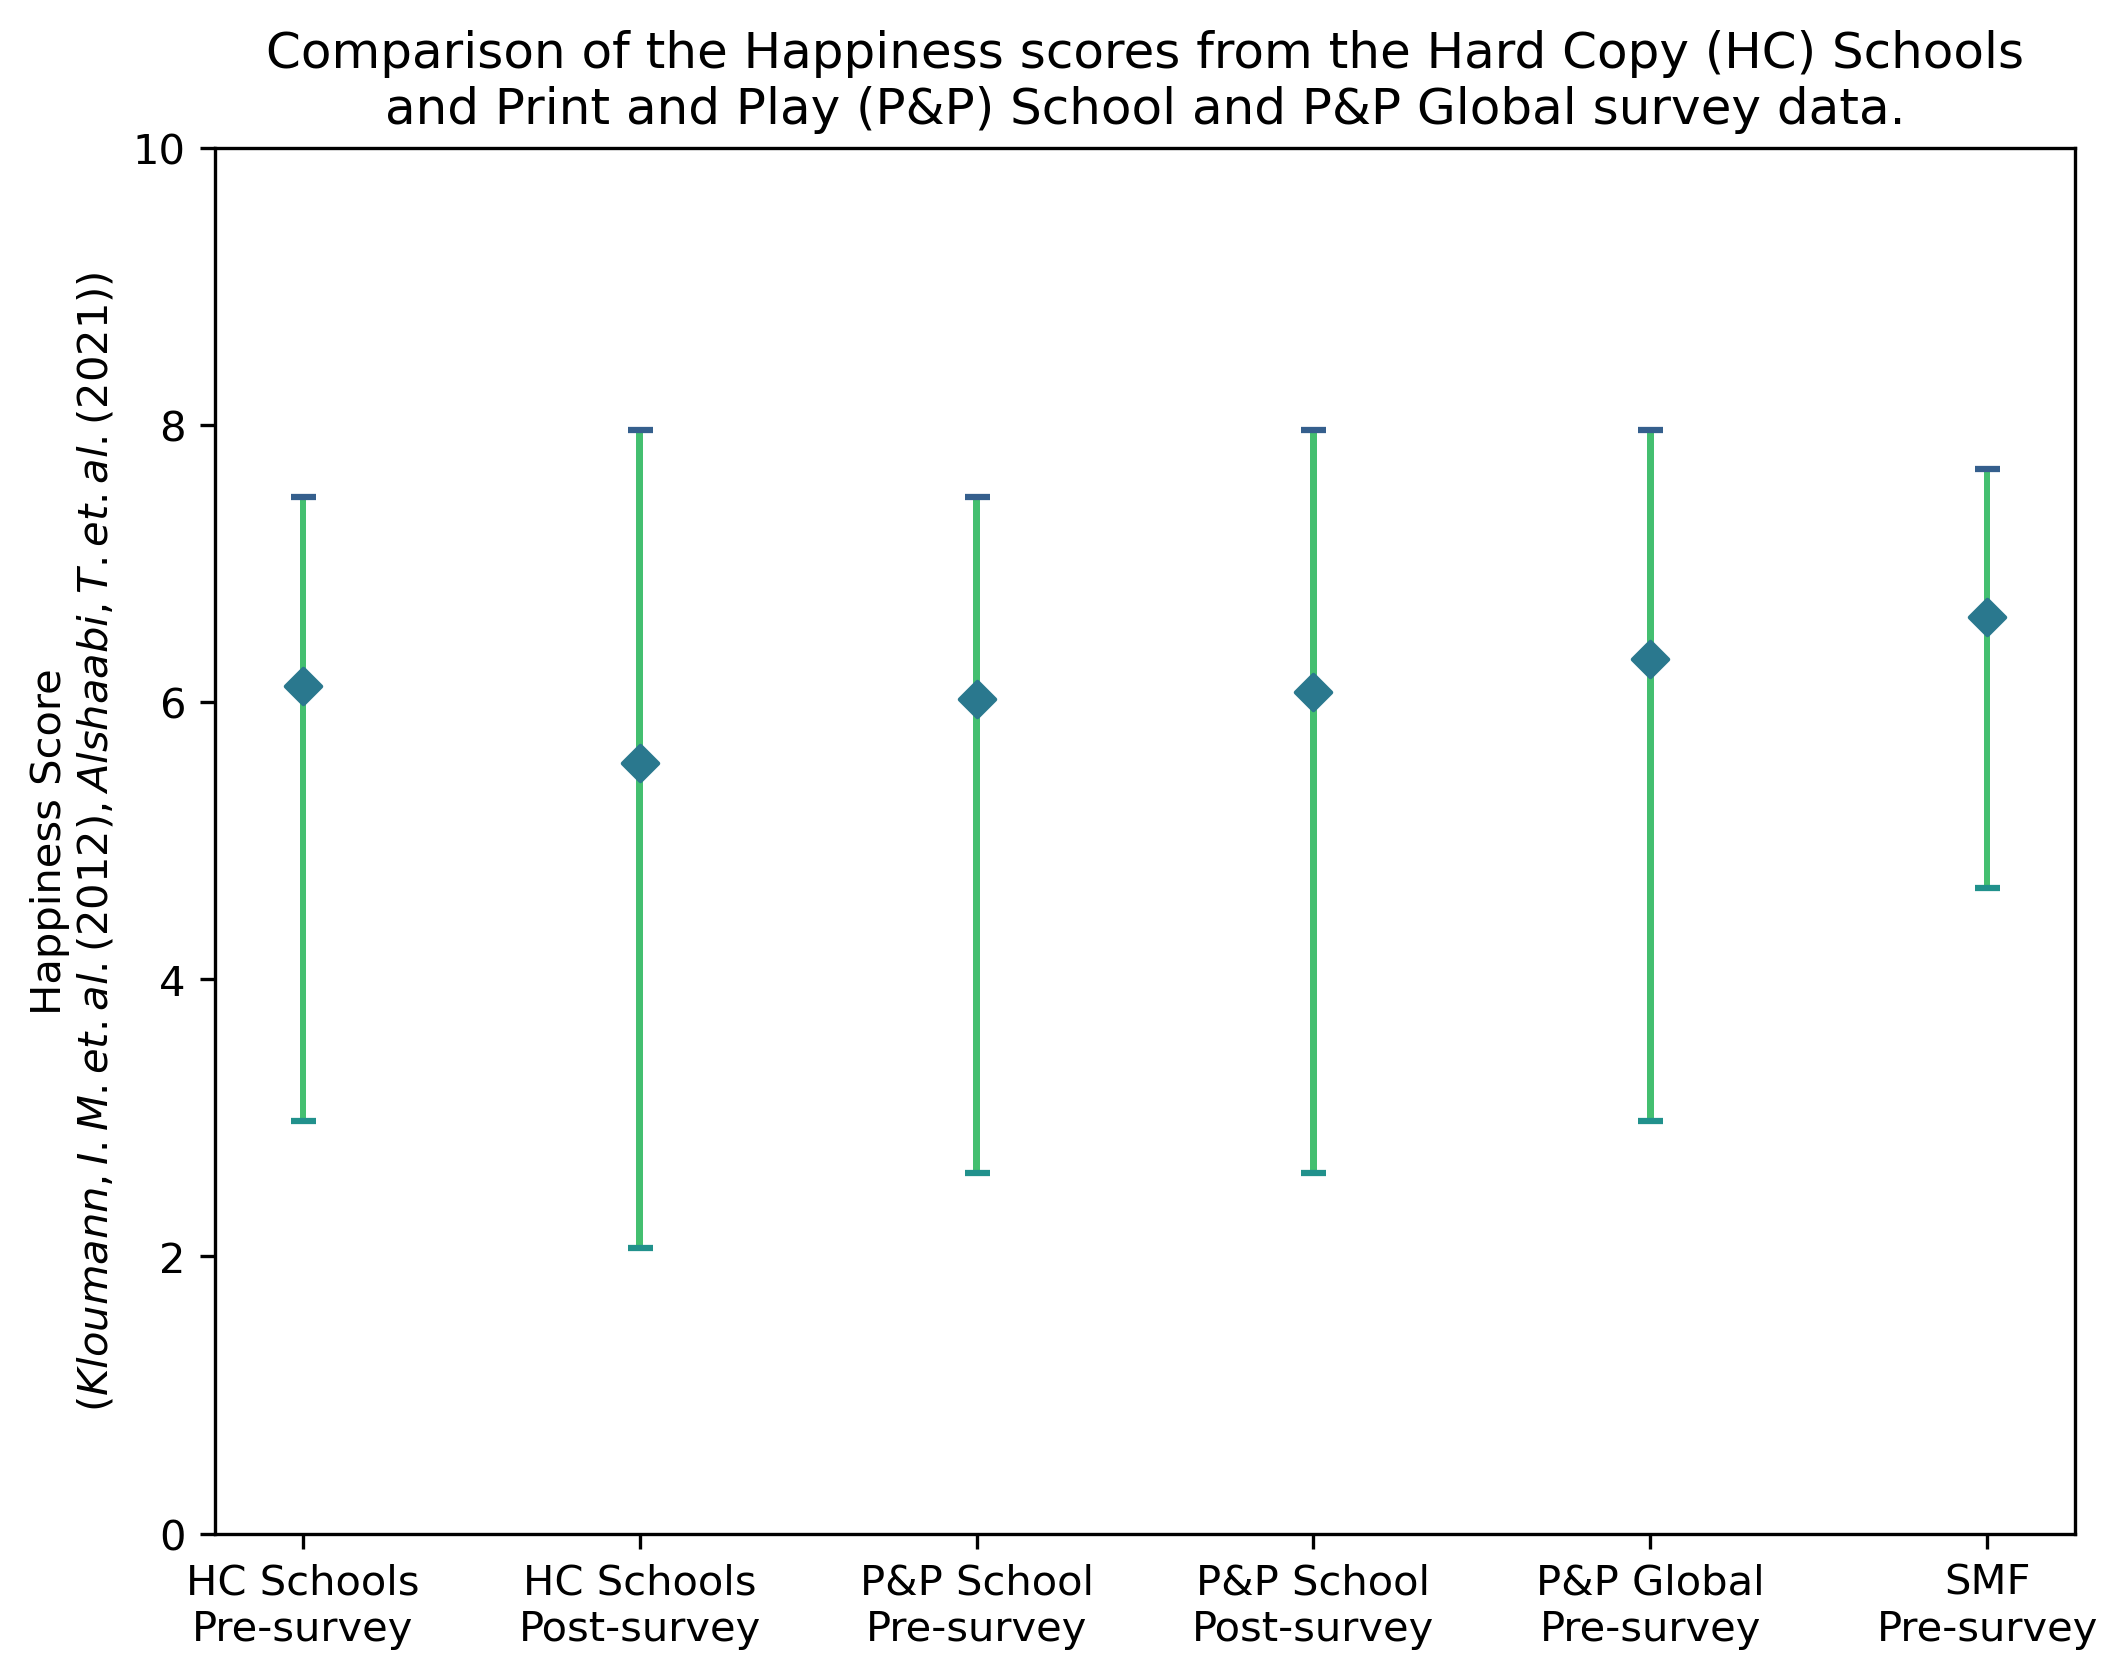

In [93]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

ax.scatter(df['Name'], df['Mean'], color=pl.cm.viridis(0.4), marker='D', label='Mean Happiness Score')
ax.scatter(df['Name'], df['Max'], color=pl.cm.viridis(0.3), marker='_', label='Max Happiness Score')
ax.scatter(df['Name'], df['Min'], color=pl.cm.viridis(0.5), marker='_', label='Min Happiness Score')
ax.bar(df['Name'], df['Max']-df['Min'], color=pl.cm.viridis(0.7), label='Max Happiness Score', width=0.02, bottom=df['Min'], zorder=-10)

#ax.set_xlabel('Study')
ax.set_ylabel('Happiness Score\n$\it{(Kloumann, I. M. et.al. (2012), Alshaabi, T. et.al. (2021))}$')
ax.set_title('Comparison of the Happiness scores from the Hard Copy (HC) Schools\nand Print and Play (P&P) School and P&P Global survey data.')
ax.set_ylim(0,10)
plt.savefig('figures/Comparison.png')

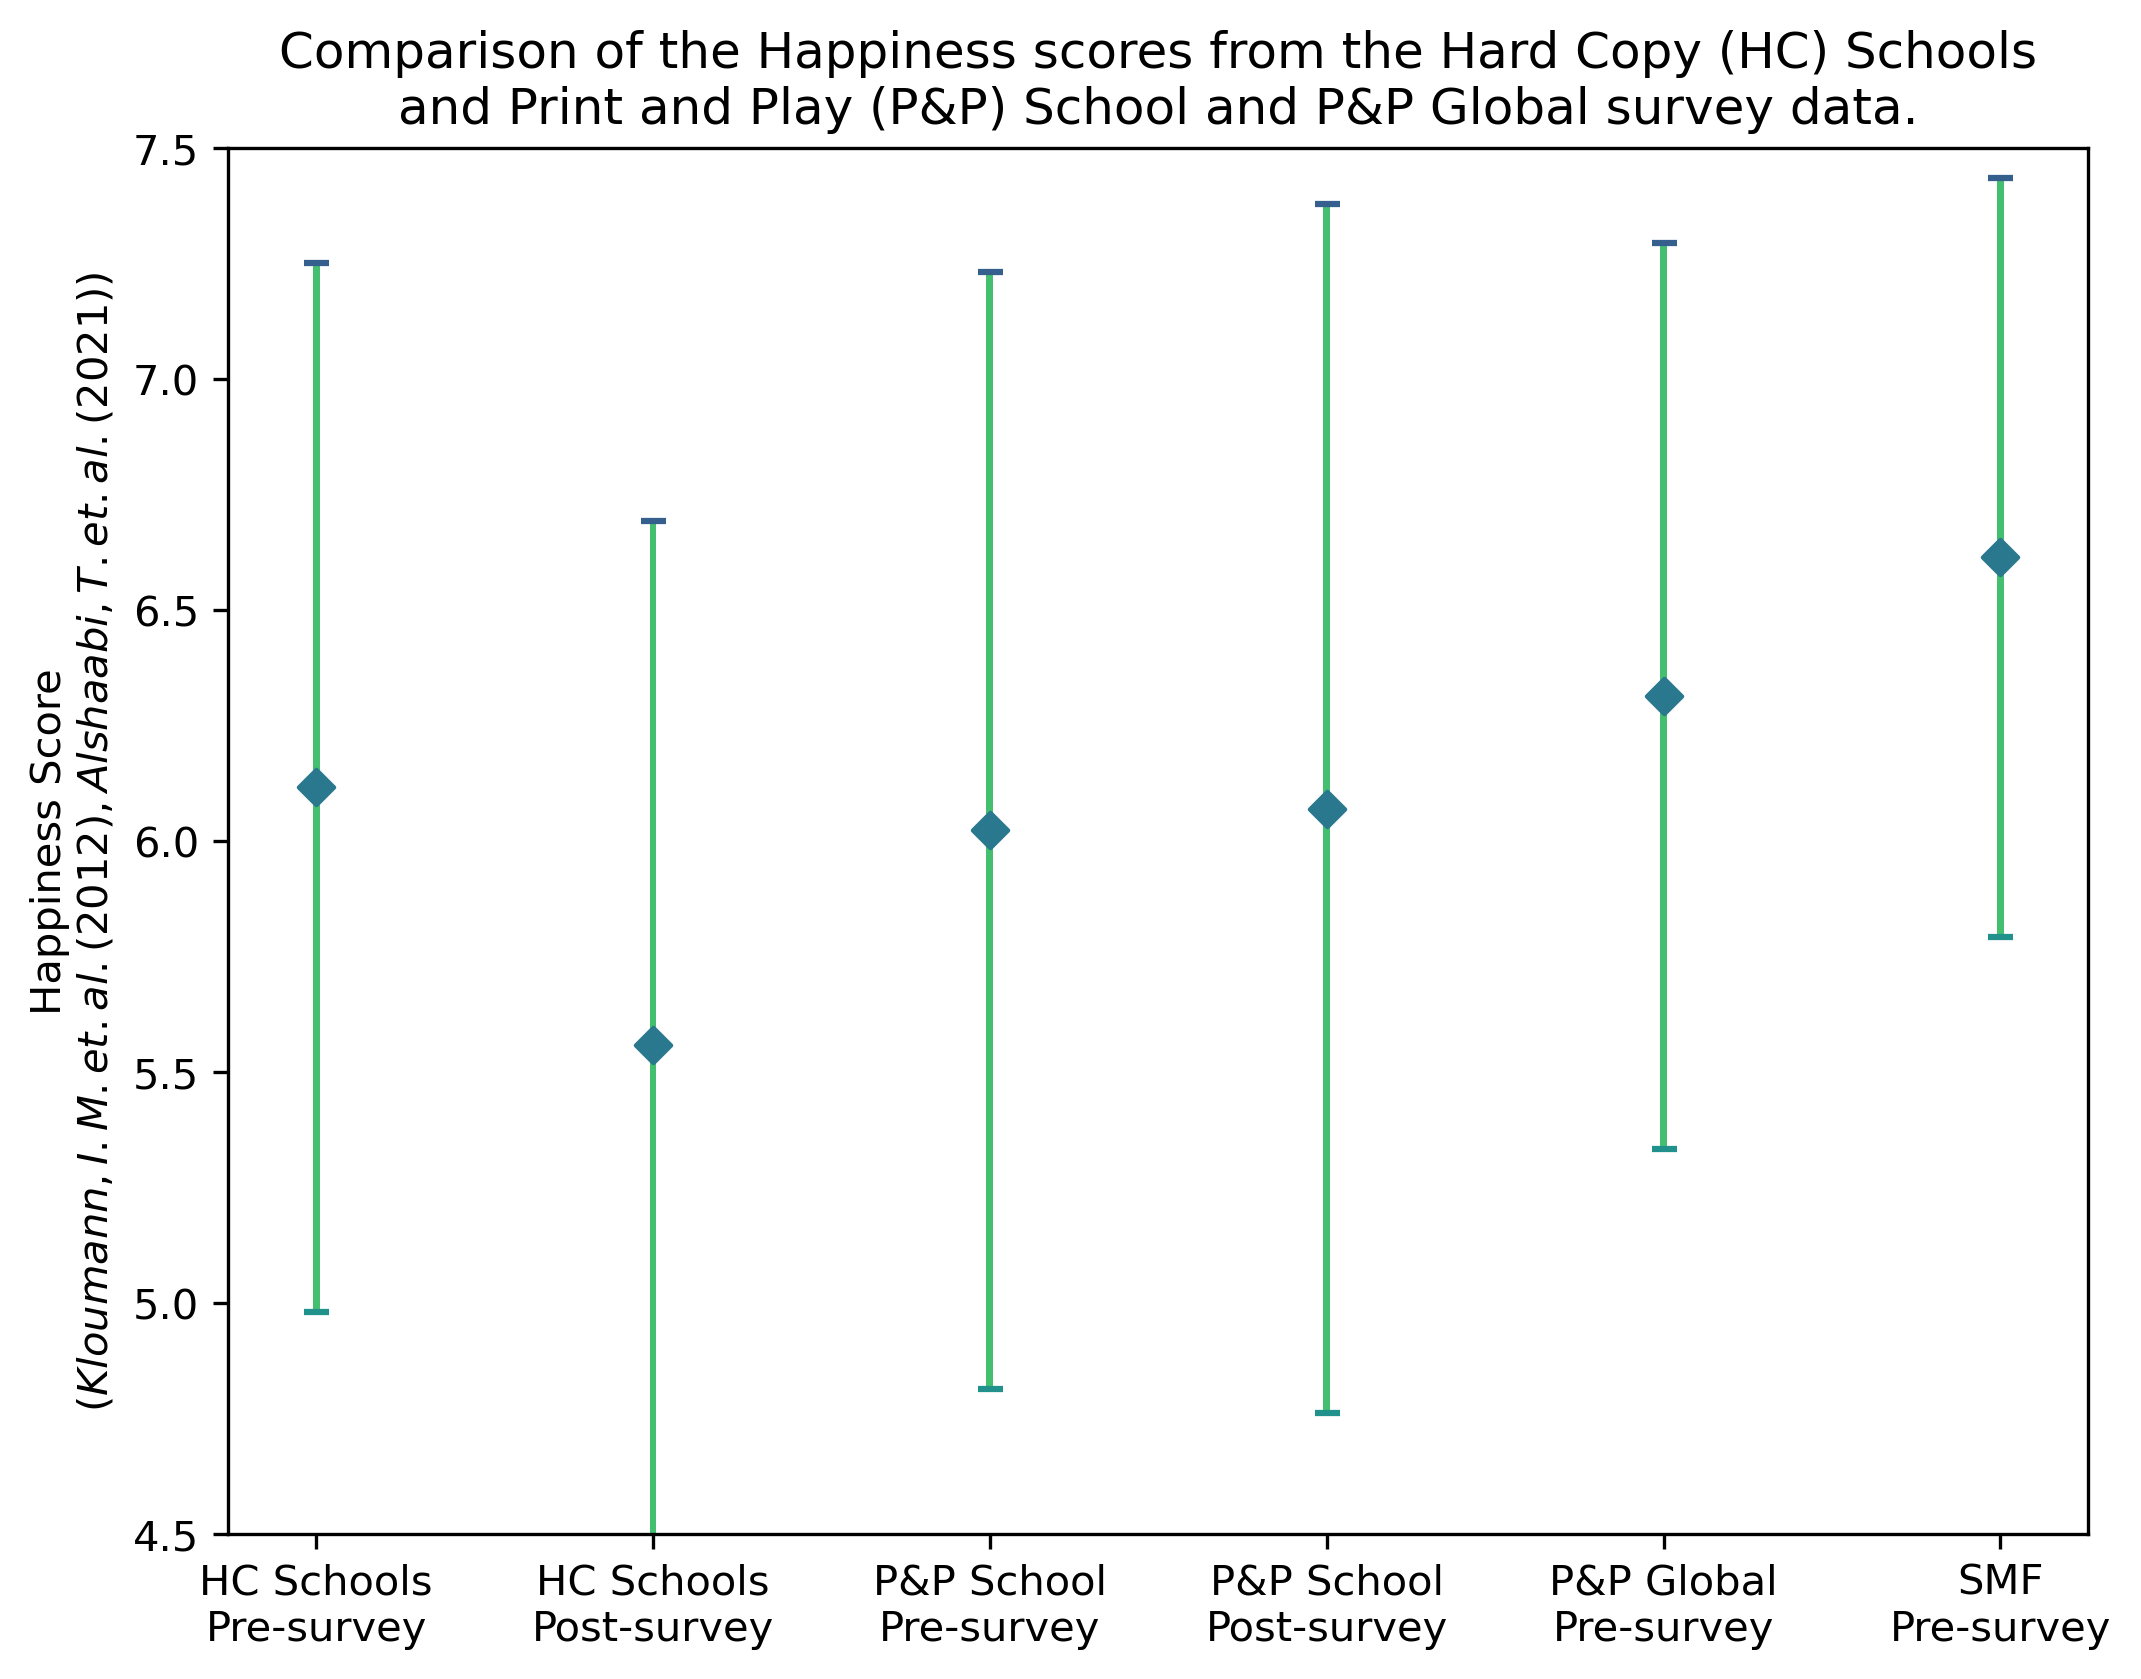

In [94]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

ax.scatter(df['Name'], df['Mean'], color=pl.cm.viridis(0.4), marker='D', label='Mean Happiness Score')
ax.scatter(df['Name'], df['Mean']+df['std'], color=pl.cm.viridis(0.3), marker='_', label='Max Happiness Score')
ax.scatter(df['Name'], df['Mean']-df['std'], color=pl.cm.viridis(0.5), marker='_', label='Min Happiness Score')
ax.bar(df['Name'], df['std']*2, color=pl.cm.viridis(0.7), label='Max Happiness Score', width=0.02, bottom=df['Mean']-df['std'], zorder=-10)

#ax.set_xlabel('Study')
ax.set_ylabel('Happiness Score\n$\it{(Kloumann, I. M. et.al. (2012), Alshaabi, T. et.al. (2021))}$')
ax.set_title('Comparison of the Happiness scores from the Hard Copy (HC) Schools\nand Print and Play (P&P) School and P&P Global survey data.')
ax.set_ylim(4.5,7.5)
plt.savefig('figures/Comparison_with_Std.png')

In [95]:
number_of_words = 70
wordcloud.generate(' '.join(original_before_words))
original_df_before = create_top_word_dataframe(wordcloud, original_before_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(original_after_words))
original_df_after = create_top_word_dataframe(wordcloud, original_after_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(rgs_before_words))
rgs_df_before = create_top_word_dataframe(wordcloud, rgs_before_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(rgs_after_words))
rgs_df_after = create_top_word_dataframe(wordcloud, rgs_after_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(pnp_before_words))
pnp_df_before = create_top_word_dataframe(wordcloud, pnp_before_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(smf_before_words))
smf_df_before = create_top_word_dataframe(wordcloud, smf_before_words, number_of_top_words=number_of_words)


In [96]:
def get_happiness(df):
    out = df['Happiness Score'][1:-1].repeat(df['Times used'][1:-1]).dropna()
    return out.values

def get_freqs(df):
    df['Corpus Frequency'][df['Corpus Frequency']<1] = 1
    df['Corpus Frequency_log10'] = np.log10(df['Corpus Frequency'])
    out = df['Corpus Frequency_log10'][1:-1].repeat(df['Times used'][1:-1]).dropna()
    return out.values

def get_ranges(df):
    out = df['Corpus Range'][1:-1].repeat(df['Times used'][1:-1]).dropna()
    return out.values

def get_disp(df):
    out = df['Corpus Disp'][1:-1].repeat(df['Times used'][1:-1]).dropna()
    return out.values

In [97]:
import math
import numpy as np

def scott_bins(data, start, stop):
    N = len(data)
    sigma = np.std(data)
    W = 3.49*sigma*(N**(-1.0/3.0))
    bins = math.ceil((stop-start)/W)
    return np.linspace(start, stop, bins+1)


C:\Users\ymq56388\AppData\Local\Temp\ipykernel_25452\1552946724.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Corpus Frequency'][df['Corpus Frequency']<1] = 1
C:\Users\ymq56388\AppData\Local\Temp\ipykernel_25452\1552946724.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Corpus Frequency'][df['Corpus Frequency']<1] = 1
C:\Users\ymq56388\AppData\Local\Temp\ipykernel_25452\1552946724.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

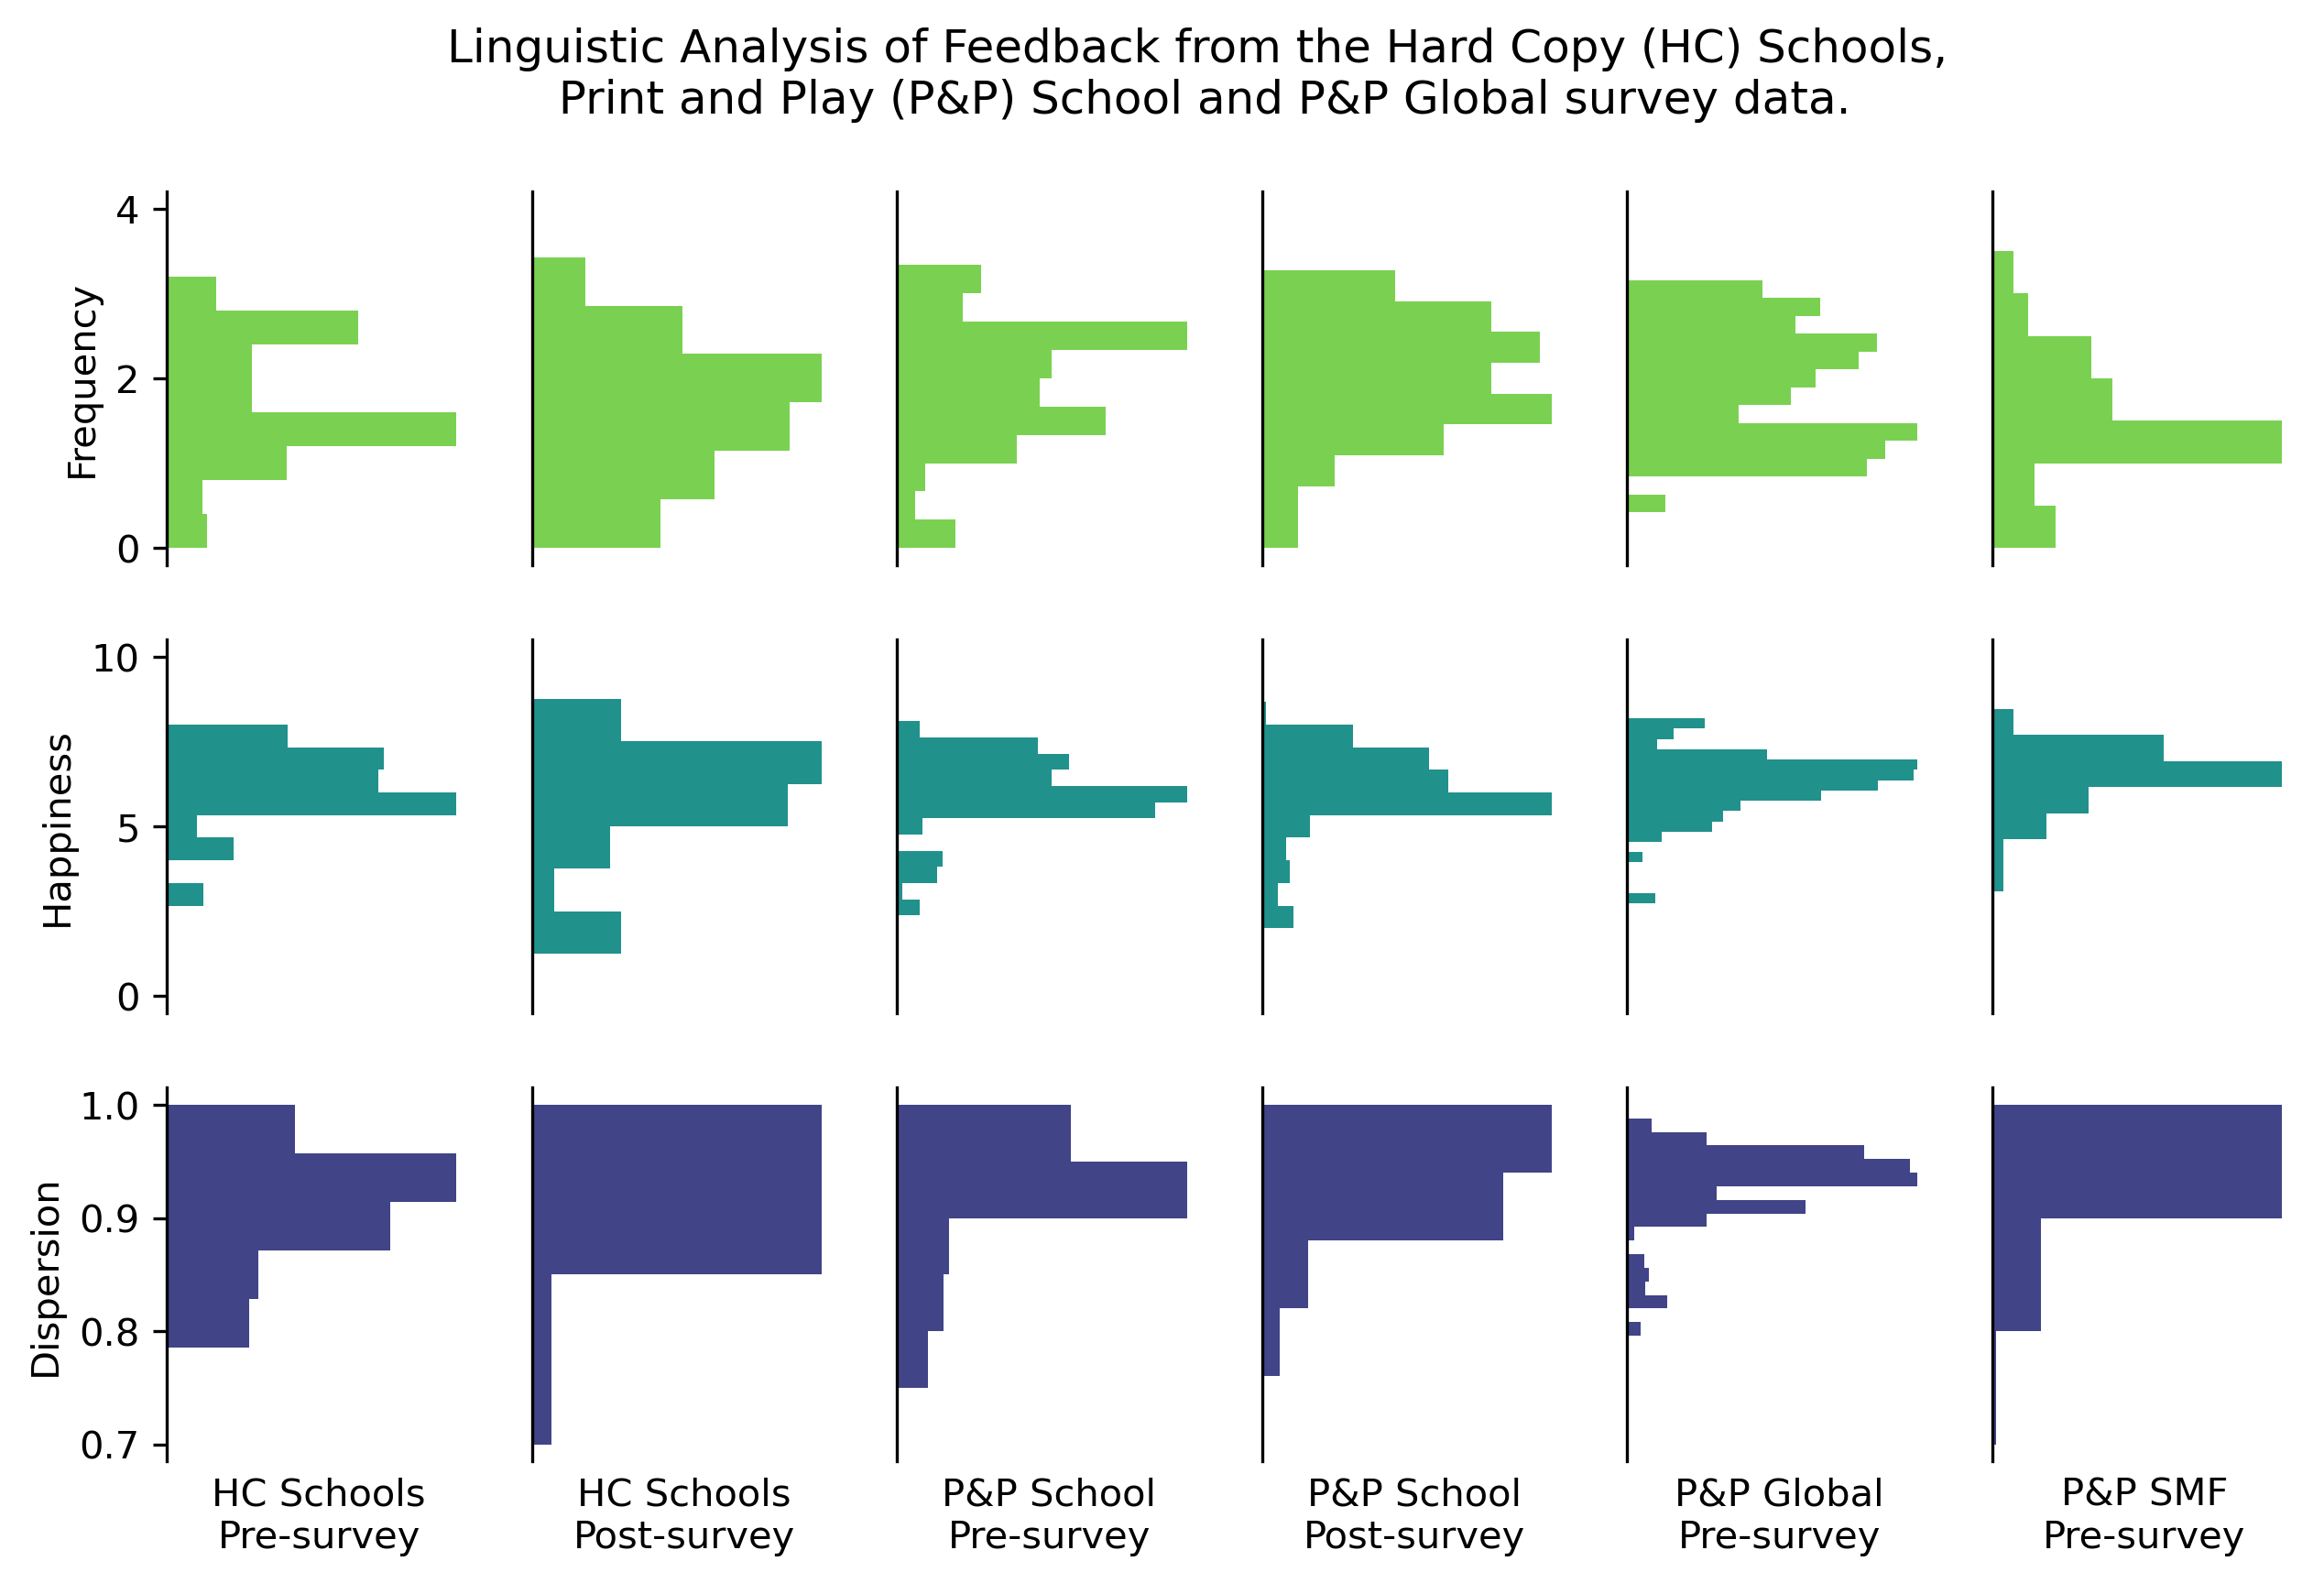

In [98]:
from matplotlib import pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 6, figsize=(10, 6), dpi=300)
for i in range(3):
    for j in range(6):
        axs[i][j].spines[['right', 'top', 'bottom']].set_visible(False)
        axs[i][j].set_xticklabels([])
        axs[i][j].set_xticks([])
        if i < 2:
            axs[i][j].get_xaxis().set_visible(False)
        if j > 0:
            axs[i][j].get_yaxis().set_visible(False)
            
fig.suptitle('Linguistic Analysis of Feedback from the Hard Copy (HC) Schools,\n Print and Play (P&P) School and P&P Global survey data.')

axs[0][0].set_ylabel('Frequency')
#axs[1][0].set_ylabel('Ranges')
axs[1][0].set_ylabel('Happiness')
axs[2][0].set_ylabel('Dispersion')

axs[2][0].set_xlabel('HC Schools\nPre-survey')
axs[2][1].set_xlabel('HC Schools\nPost-survey')
axs[2][2].set_xlabel('P&P School\nPre-survey')
axs[2][3].set_xlabel('P&P School\nPost-survey')
axs[2][4].set_xlabel('P&P Global\nPre-survey')
axs[2][5].set_xlabel('P&P SMF\nPre-survey')


data = get_freqs(original_df_before);
axs[0][0].hist(data, bins=scott_bins(data,0,4), orientation="horizontal", color=pl.cm.viridis(0.8))
#data = get_ranges(original_df_before)
#axs[1][0].hist(data, bins=scott_bins(data,80,100), orientation="horizontal", color=pl.cm.viridis(0.6))
data = get_happiness(original_df_before)
axs[1][0].hist(data, bins=scott_bins(data,0,10), orientation="horizontal", color=pl.cm.viridis(0.5))
data = get_disp(original_df_before)
axs[2][0].hist(data, bins=scott_bins(data,0.7,1.0), orientation="horizontal", color=pl.cm.viridis(0.2))


data = get_freqs(original_df_after)
axs[0][1].hist(data, bins=scott_bins(data,0,4), orientation="horizontal", color=pl.cm.viridis(0.8))
#data = get_ranges(original_df_after)
#axs[1][1].hist(data, bins=scott_bins(data,80,100), orientation="horizontal", color=pl.cm.viridis(0.6))
data = get_happiness(original_df_after)
axs[1][1].hist(data, bins=scott_bins(data,0,10), orientation="horizontal", color=pl.cm.viridis(0.5))
data = get_disp(original_df_after)
axs[2][1].hist(data, bins=scott_bins(data,0.7,1.0), orientation="horizontal", color=pl.cm.viridis(0.2))


data = get_freqs(rgs_df_before)
axs[0][2].hist(data, bins=scott_bins(data,0,4), orientation="horizontal", color=pl.cm.viridis(0.8))
#data = get_ranges(rgs_df_before)
#axs[1][2].hist(data, bins=scott_bins(data,80,100), orientation="horizontal", color=pl.cm.viridis(0.6))
data = get_happiness(rgs_df_before)
axs[1][2].hist(data, bins=scott_bins(data,0,10), orientation="horizontal", color=pl.cm.viridis(0.5))
data = get_disp(rgs_df_before)
axs[2][2].hist(data, bins=scott_bins(data,0.7,1.0), orientation="horizontal", color=pl.cm.viridis(0.2))


data = get_freqs(rgs_df_after)
axs[0][3].hist(data, bins=scott_bins(data,0,4), orientation="horizontal", color=pl.cm.viridis(0.8))
#data = get_ranges(rgs_df_after)
#axs[1][3].hist(data, bins=scott_bins(data,80,100), orientation="horizontal", color=pl.cm.viridis(0.6))
data = get_happiness(rgs_df_after)
axs[1][3].hist(data, bins=scott_bins(data,0,10), orientation="horizontal", color=pl.cm.viridis(0.5))
data = get_disp(rgs_df_after)
axs[2][3].hist(data, bins=scott_bins(data,0.7,1.0), orientation="horizontal", color=pl.cm.viridis(0.2))


data = get_freqs(pnp_df_before)
axs[0][4].hist(data, bins=scott_bins(data,0,4), orientation="horizontal", color=pl.cm.viridis(0.8))
#data = get_ranges(pnp_df_before)
#axs[1][4].hist(data, bins=scott_bins(data,80,100), orientation="horizontal", color=pl.cm.viridis(0.6))
data = get_happiness(pnp_df_before)
axs[1][4].hist(data, bins=scott_bins(data,0,10), orientation="horizontal", color=pl.cm.viridis(0.5))
data = get_disp(pnp_df_before)
axs[2][4].hist(data, bins=scott_bins(data,0.7,1.0), orientation="horizontal", color=pl.cm.viridis(0.2))

data = get_freqs(smf_df_before)
axs[0][5].hist(data, bins=scott_bins(data,0,4), orientation="horizontal", color=pl.cm.viridis(0.8))
#data = get_ranges(pnp_df_before)
#axs[1][4].hist(data, bins=scott_bins(data,80,100), orientation="horizontal", color=pl.cm.viridis(0.6))
data = get_happiness(smf_df_before)
axs[1][5].hist(data, bins=scott_bins(data,0,10), orientation="horizontal", color=pl.cm.viridis(0.5))
data = get_disp(smf_df_before)
axs[2][5].hist(data, bins=scott_bins(data,0.7,1.0), orientation="horizontal", color=pl.cm.viridis(0.2))

plt.savefig('figures/WordAnalysis.png')
plt.show()


<Axes: xlabel='Corpus Disp', ylabel='Happiness Score'>

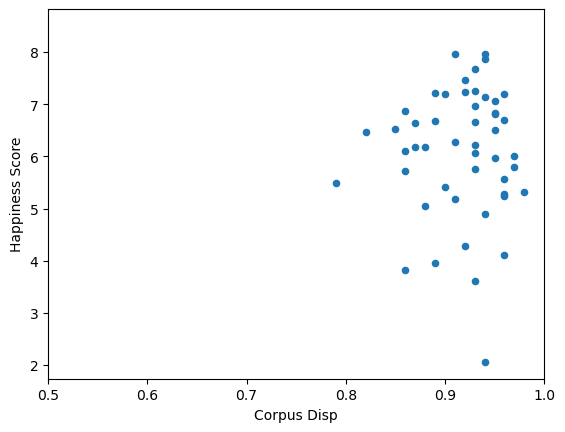

In [99]:
original_df_after.plot('Corpus Disp', 'Happiness Score', kind='scatter',
                      xlim=(0.5,1.0))

<Axes: xlabel='Corpus Disp', ylabel='Happiness Score'>

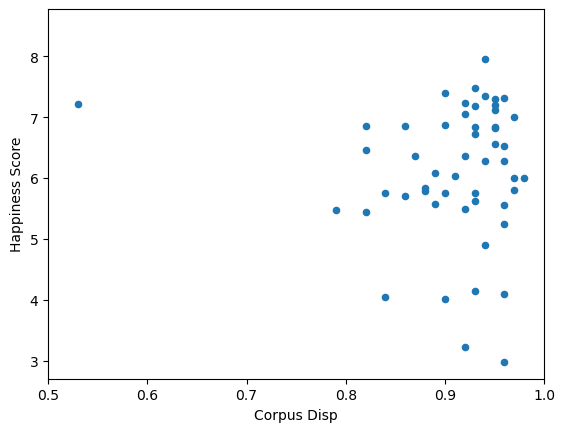

In [100]:
original_df_before.plot('Corpus Disp', 'Happiness Score', kind='scatter',
                     xlim=(0.5,1.0))

<Axes: xlabel='Corpus Disp', ylabel='Happiness Score'>

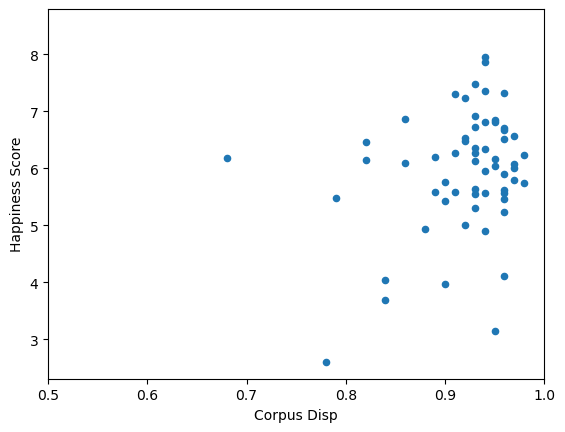

In [101]:
rgs_df_before.plot('Corpus Disp', 'Happiness Score', kind='scatter',
                  xlim=(0.5,1.0))

<Axes: xlabel='Corpus Disp', ylabel='Happiness Score'>

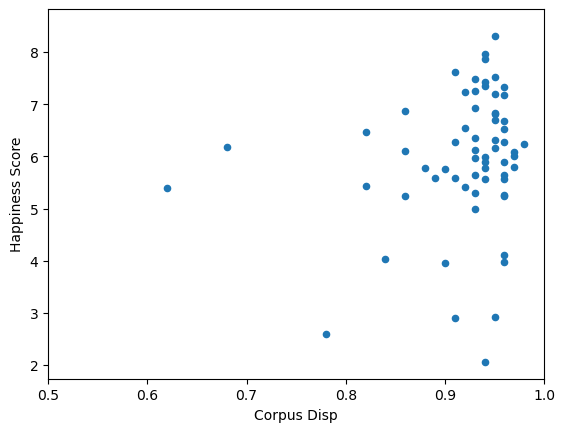

In [102]:
rgs_df_after.plot('Corpus Disp', 'Happiness Score', kind='scatter',
                      xlim=(0.5,1.0))

<Axes: xlabel='Corpus Disp', ylabel='Happiness Score'>

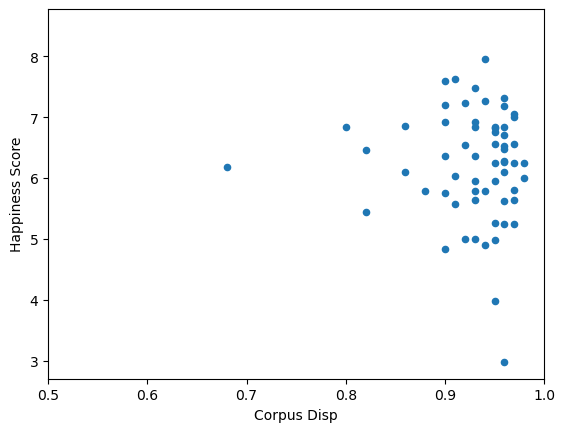

In [103]:
pnp_df_before.plot('Corpus Disp', 'Happiness Score', kind='scatter',
                      xlim=(0.5,1.0))

In [104]:
original_df_after

,Word,Times used,Happiness Score,Happiness StDev,Corpus Frequency,Corpus Range,Corpus Disp,Examples,Weighted mean,Corpus Frequency_log10
0,laughter,NaN,8.50,NaN,NaN,NaN,22.00,8.50,5.763784,NaN
1,fun,2.0,7.96,1.31,51.0,98.0,0.94,NaN,5.763784,1.707570
2,loving,1.0,7.96,1.01,14.0,94.0,0.91,NaN,5.763784,1.146128
3,success,4.0,7.86,1.64,134.0,100.0,0.94,NaN,5.763784,2.127105
4,lucky,1.0,7.68,1.27,41.0,98.0,0.93,NaN,5.763784,1.612784
...,...,...,...,...,...,...,...,...,...,...
67,tiring,1.0,NaN,NaN,3.0,83.0,0.91,NaN,5.763784,0.477121
68,collaberation,1.0,NaN,NaN,1.0,0.0,0.00,NaN,5.763784,0.000000
69,insightful,1.0,NaN,NaN,1.0,18.0,0.75,NaN,5.763784,0.000000
70,curiosity,1.0,NaN,NaN,12.0,92.0,0.91,NaN,5.763784,1.079181


In [105]:
number_of_words = None

wordcloud.generate(' '.join(original_before_words))
original_df_before = create_top_word_dataframe(wordcloud, original_before_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(original_after_words))
original_df_after = create_top_word_dataframe(wordcloud, original_after_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(rgs_before_words))
rgs_df_before = create_top_word_dataframe(wordcloud, rgs_before_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(rgs_after_words))
rgs_df_after = create_top_word_dataframe(wordcloud, rgs_after_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(pnp_before_words))
pnp_df_before = create_top_word_dataframe(wordcloud, pnp_before_words, number_of_top_words=number_of_words)

wordcloud.generate(' '.join(smf_before_words))
smf_df_before = create_top_word_dataframe(wordcloud, smf_before_words, number_of_top_words=number_of_words)

New number of words 121
New number of words 74
New number of words 198
New number of words 173
New number of words 760
New number of words 74


In [106]:
# This is a bit of a mess, but it is extracting information for Tables 6 and 7 in the paper.

print('original_df_before')
data = original_df_before
print(data['Times used'].sum())
print(data['Times used'].count())
print(data['Happiness Score'].count()-2) # -2 to get rid of the example words.(laughter and sadness)

print('original_df_after')
data = original_df_after
print(data['Times used'].sum())
print(data['Times used'].count())
print(data['Happiness Score'].count()-2)

print('rgs_df_before')
data = rgs_df_before
print(data['Times used'].sum())
print(data['Times used'].count())
print(data['Happiness Score'].count()-2)

print('rgs_df_after')
data = rgs_df_after
print(data['Times used'].sum())
print(data['Times used'].count())
print(data['Happiness Score'].count()-2)

print('pnp_df_before')
data = pnp_df_before
print(data['Times used'].sum())
print(data['Times used'].count())
print(data['Happiness Score'].count()-2)

print('smf_df_before')
data = smf_df_before
print(data['Times used'].sum())
print(data['Times used'].count())
print(data['Happiness Score'].count()-2)
print(get_freqs(data).mean())
print(get_happiness(data).mean())
print(get_disp(data).mean())


original_df_before
252.0
121
87
original_df_after
103.0
74
52
rgs_df_before
608.0
198
146
rgs_df_after
349.0
173
144
pnp_df_before
2515.0
760
544
smf_df_before
99.0
74
49
1.443304677593264
6.462380952380953
0.8884848484848485


C:\Users\ymq56388\AppData\Local\Temp\ipykernel_25452\1552946724.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Corpus Frequency'][df['Corpus Frequency']<1] = 1


In [107]:
(87+52+146+144+171+47)/(121+74+198+173+200+70) # Overall Percentage of words with happiness scores.

0.7739234449760766